First figure of the manuscript, showing "broadband" timescales. 
- Brain maps of timescales across wake and sleep stages.
- Overall timescales changes in wake and sleep across all brain areas.
- Correlation sizes of timescales with T1w/T2w score.

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import mne
import nibabel as nib
import pickle

from mnitimescales import utils
from mnitimescales import plots
import mnitimescales.sw.plots as plots_sw

plots._set_font_params()

Imports and definitions:

In [3]:
stages = ["N2", "N3"]
stage_colors = {"N2": "cyan", "N3": "purple"}
title_dict = {"N2": "NREM2", "N3": "NREM3"}
corr_type = "pearson"

# Paths
data_path = Path("F:\\MNIOpen")
sw_path = data_path.joinpath("Results", "sw_analysis")
tau_path = data_path.joinpath("Results", "timescales_broadband_10min")
tau_gamma_path = data_path.joinpath("Results", "timescales_gamma_10min")
fig_path = data_path.joinpath("Figures", "Fig_sw")
fig_path.mkdir(exist_ok=True, parents=True)
df_density_stages = {
    stage: pd.read_csv(sw_path.joinpath(f"density_total_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
df_density_stages_local = {
    stage: pd.read_csv(sw_path.joinpath(f"density_local_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
df_density_stages_global = {
    stage: pd.read_csv(sw_path.joinpath(f"density_global_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
# Timescales
df_timescales_stages = {
    stage: pd.read_csv(tau_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
df_timescales_stages_gamma = {
    stage: pd.read_csv(tau_gamma_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

# Parcellation
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

Reading labels from parcellation...
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.HCPMMP1.annot


### A) Plot of parcellated brain areas

#### "Total" SWs density

In [4]:
minmax_stages = {"N2": (3.5, 5.5), "N3": (4.6, 7.1)}

# Loop through stages
for stage in stages:

    fig, ax = plots.plot_parcellated_metric(
        df_density_stages[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="SWs / min",
        cbar_format="0f",
    )

    fig.savefig(
        fig_path.joinpath(f"sw_parc_{stage}.svg"),
        format="svg",
        transparent=True,
    )
    plt.close(fig)

Using pyvistaqt 3d backend.



c:\Users\ricca\anaconda3\envs\mni_analysis\lib\site-packages\pyvista\plotting\plotting\__init__.py:23: PyVistaDeprecationWarning: The `pyvista.plotting.plotting` module has been deprecated. `_ALL_PLOTTERS` is now imported as: `from pyvista.plotting import _ALL_PLOTTERS`.
  warnings.warn(


#### "Local" SWs density

In [5]:
minmax_stages = {"N2": (1.7, 2.9), "N3": (2.2, 4.2)}

# Loop through stages
for stage in stages:

    fig, ax = plots.plot_parcellated_metric(
        df_density_stages_local[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="SWs / min",
        cbar_format="0f",
    )

    fig.savefig(
        fig_path.joinpath(f"sw_loc_parc_{stage}.svg"),
        format="svg",
        transparent=True,
    )
    plt.close(fig)

#### "Global" SWs density

In [6]:
minmax_stages = {"N2": (1.6, 3.1), "N3": (2, 3.7)}

# Loop through stages
for stage in stages:

    fig, ax = plots.plot_parcellated_metric(
        df_density_stages_global[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="SWs / min",
        cbar_format="0f",
    )

    fig.savefig(
        fig_path.joinpath(f"sw_glo_parc_{stage}.svg"),
        format="svg",
        transparent=True,
    )
    plt.close(fig)

### B) Correlation with timescales

Load centroids coordinates of the parcellation (for spin permutation):

In [7]:
map_coords = pd.read_csv(
    data_path.joinpath("Data", "Parcellation", "mmp_centroids_coords.csv"), index_col=0
)

#### Broadband timescales

Generating 1000 permutations...
Generating 1000 permutations...


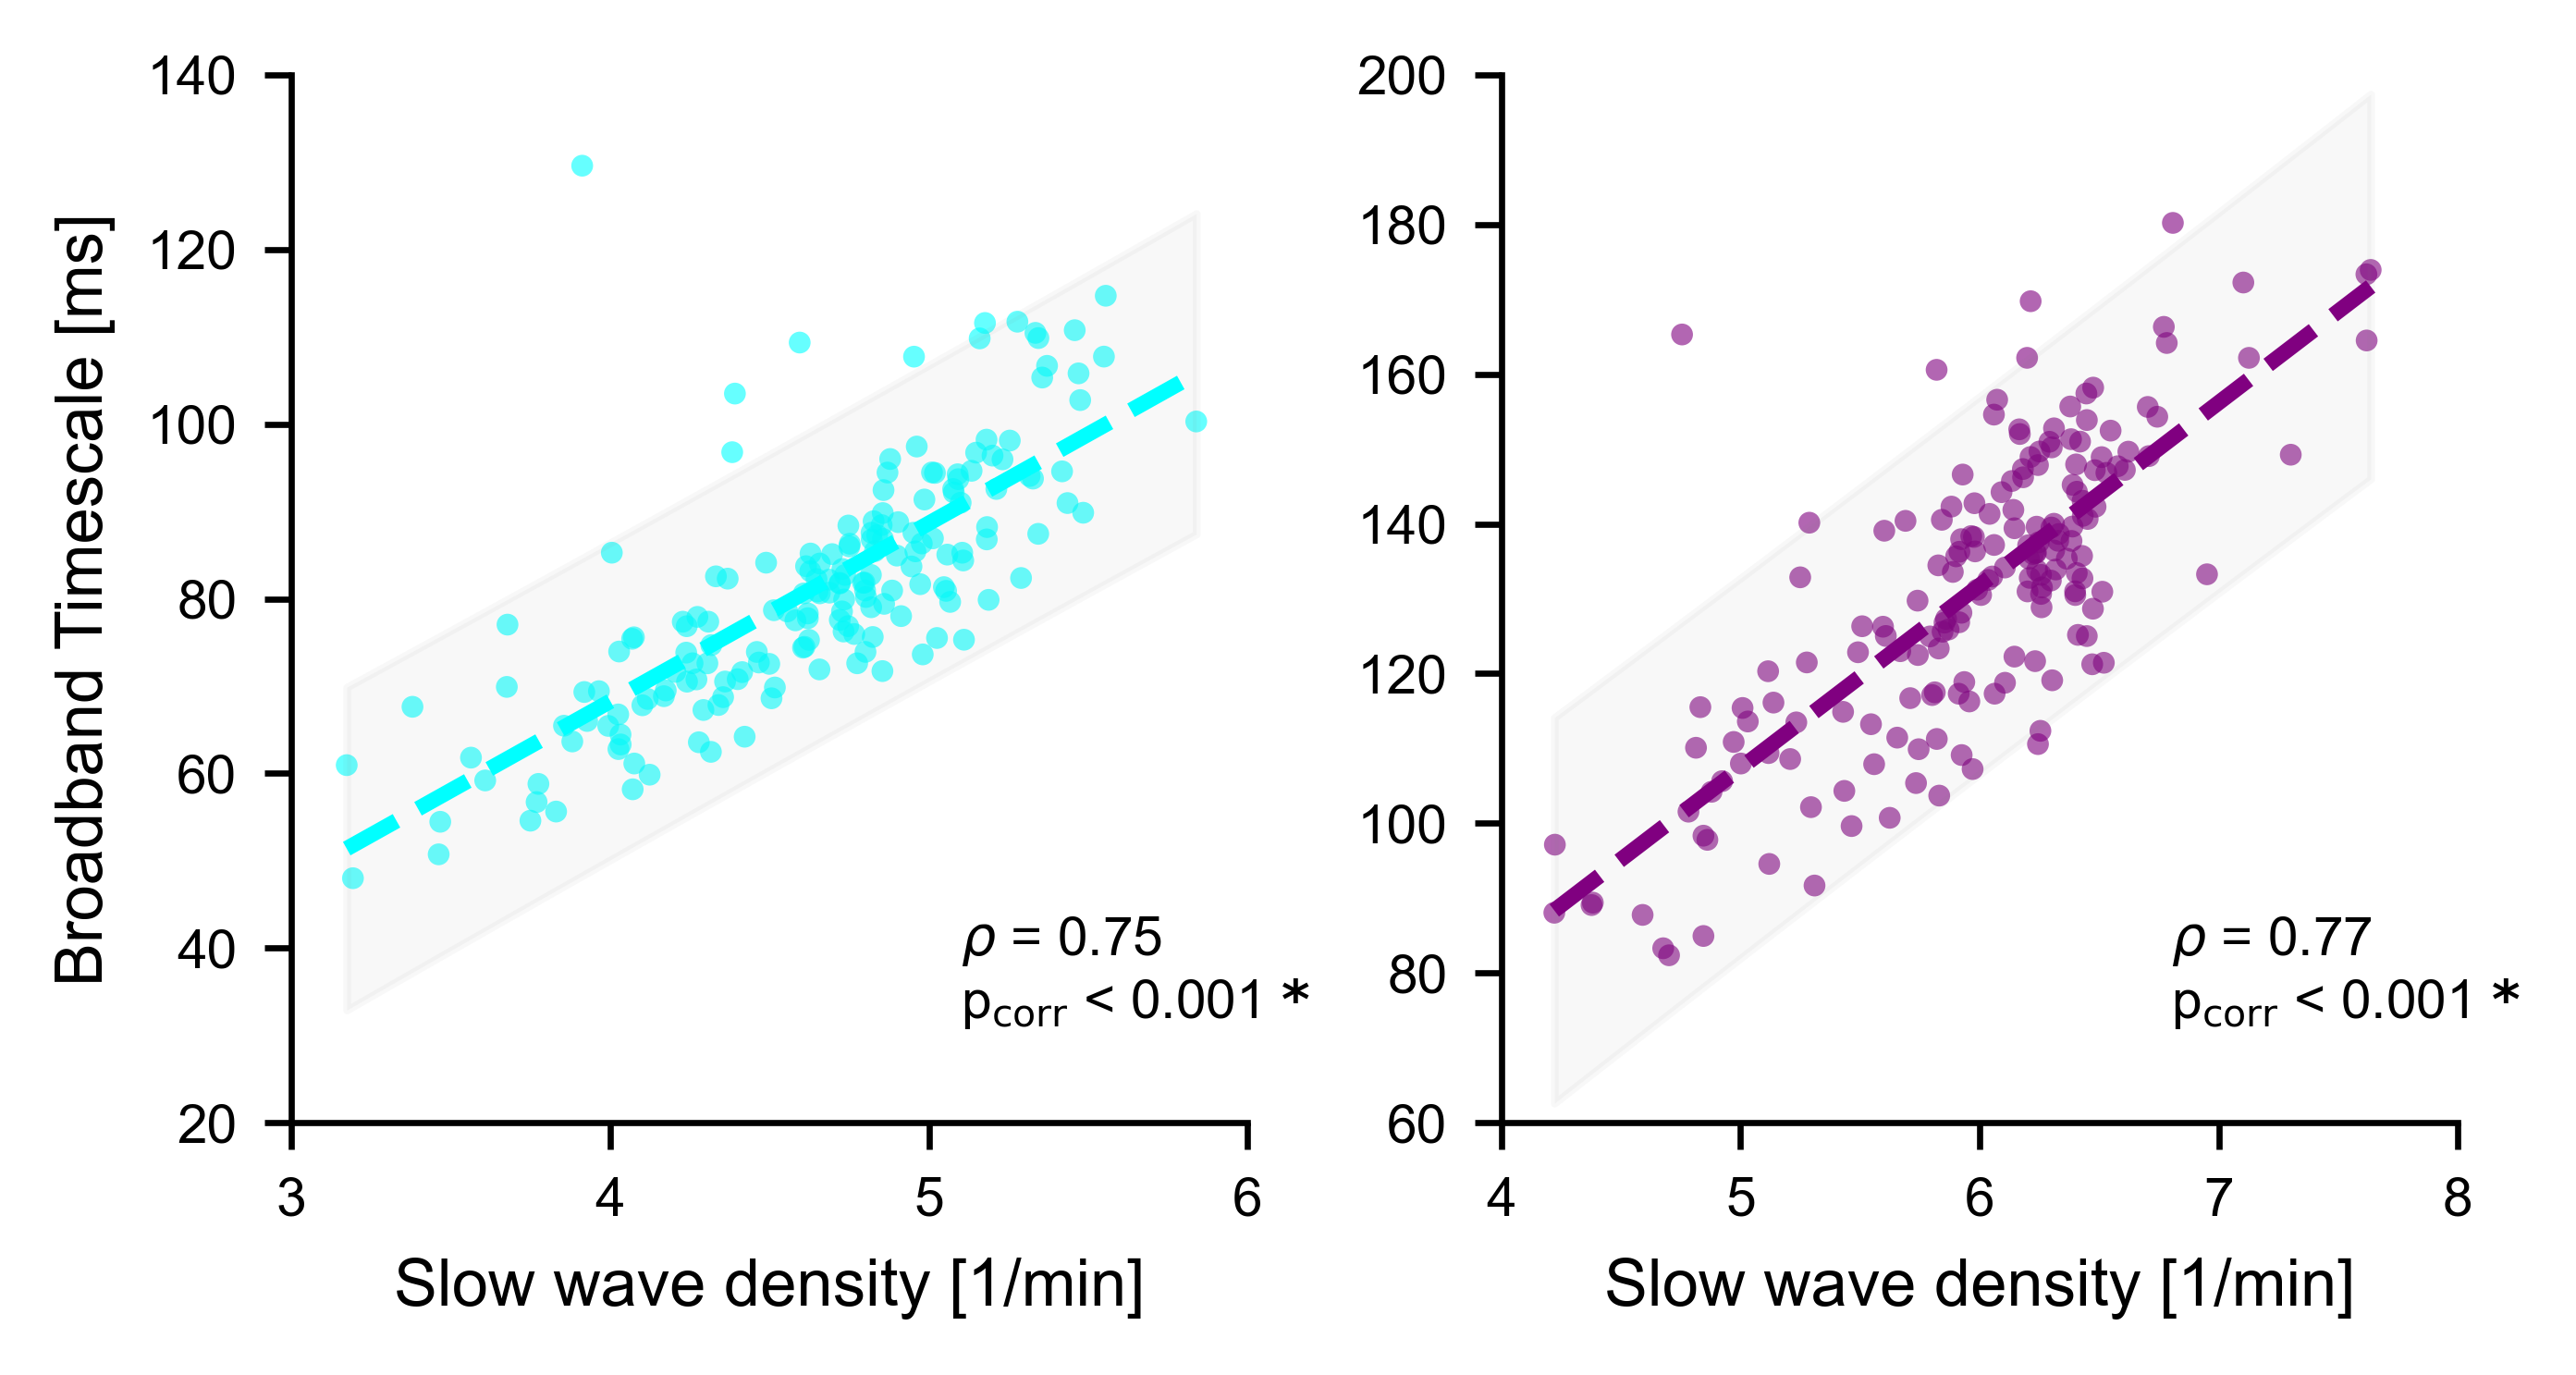

Generating 1000 permutations...
Generating 1000 permutations...


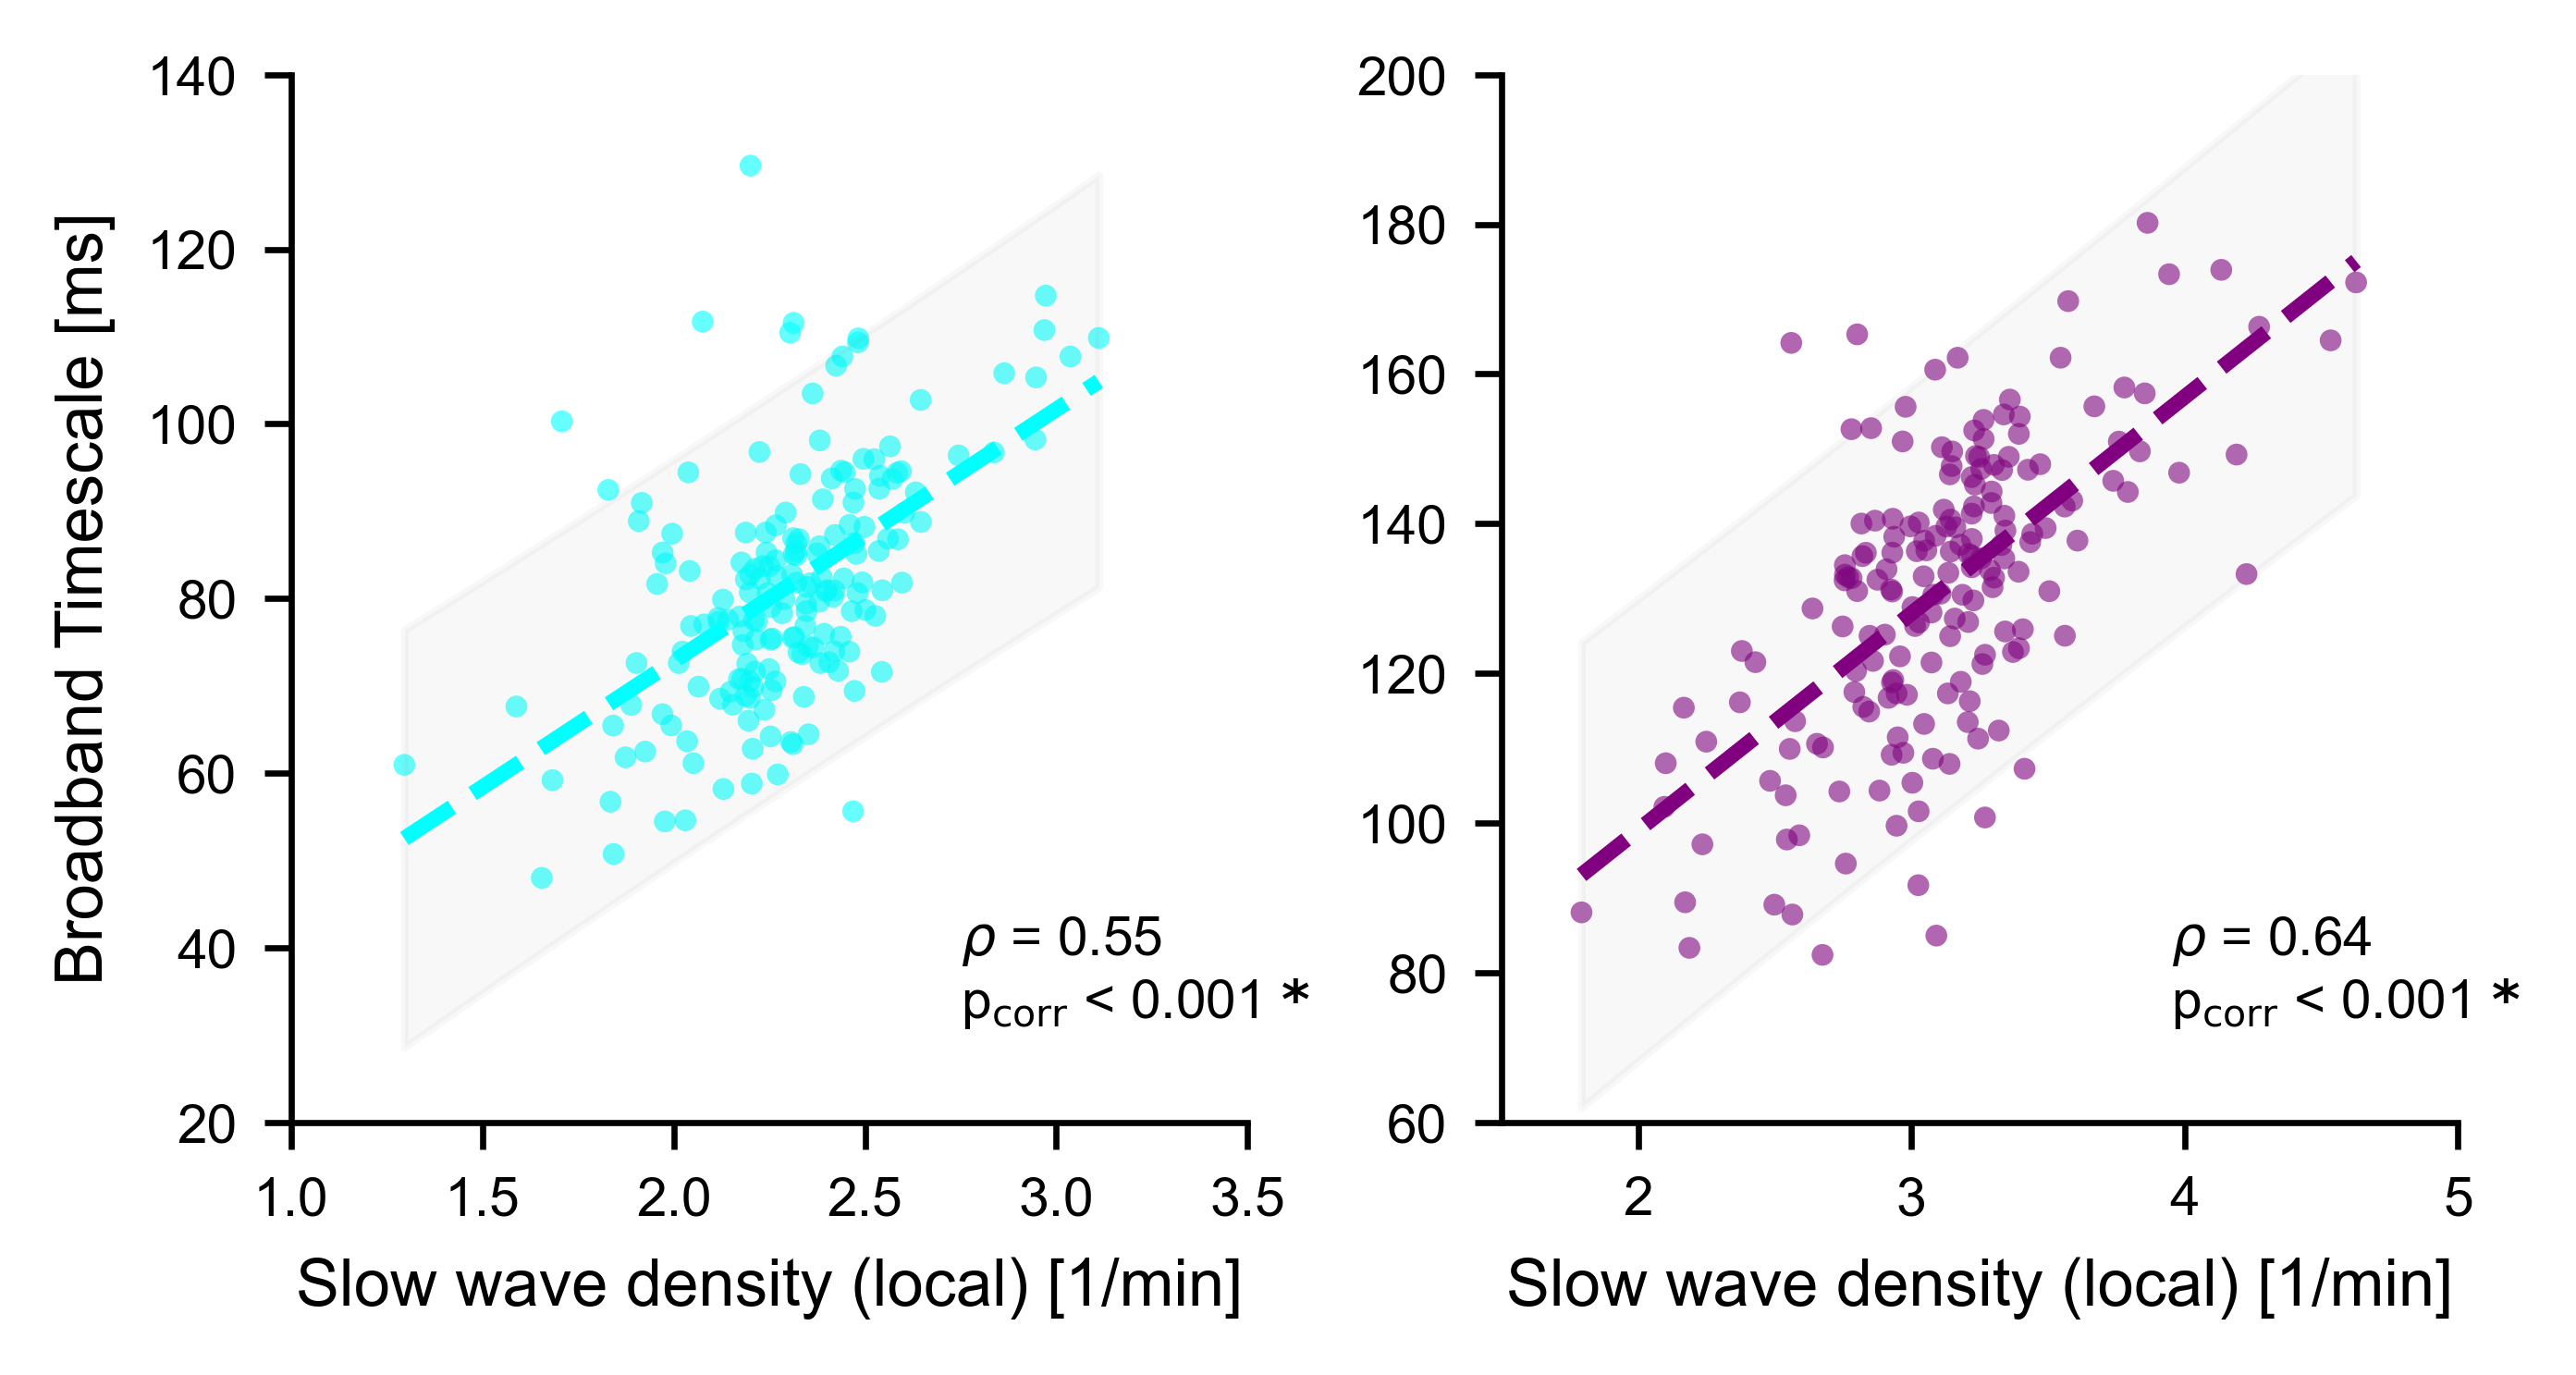

Generating 1000 permutations...
Generating 1000 permutations...


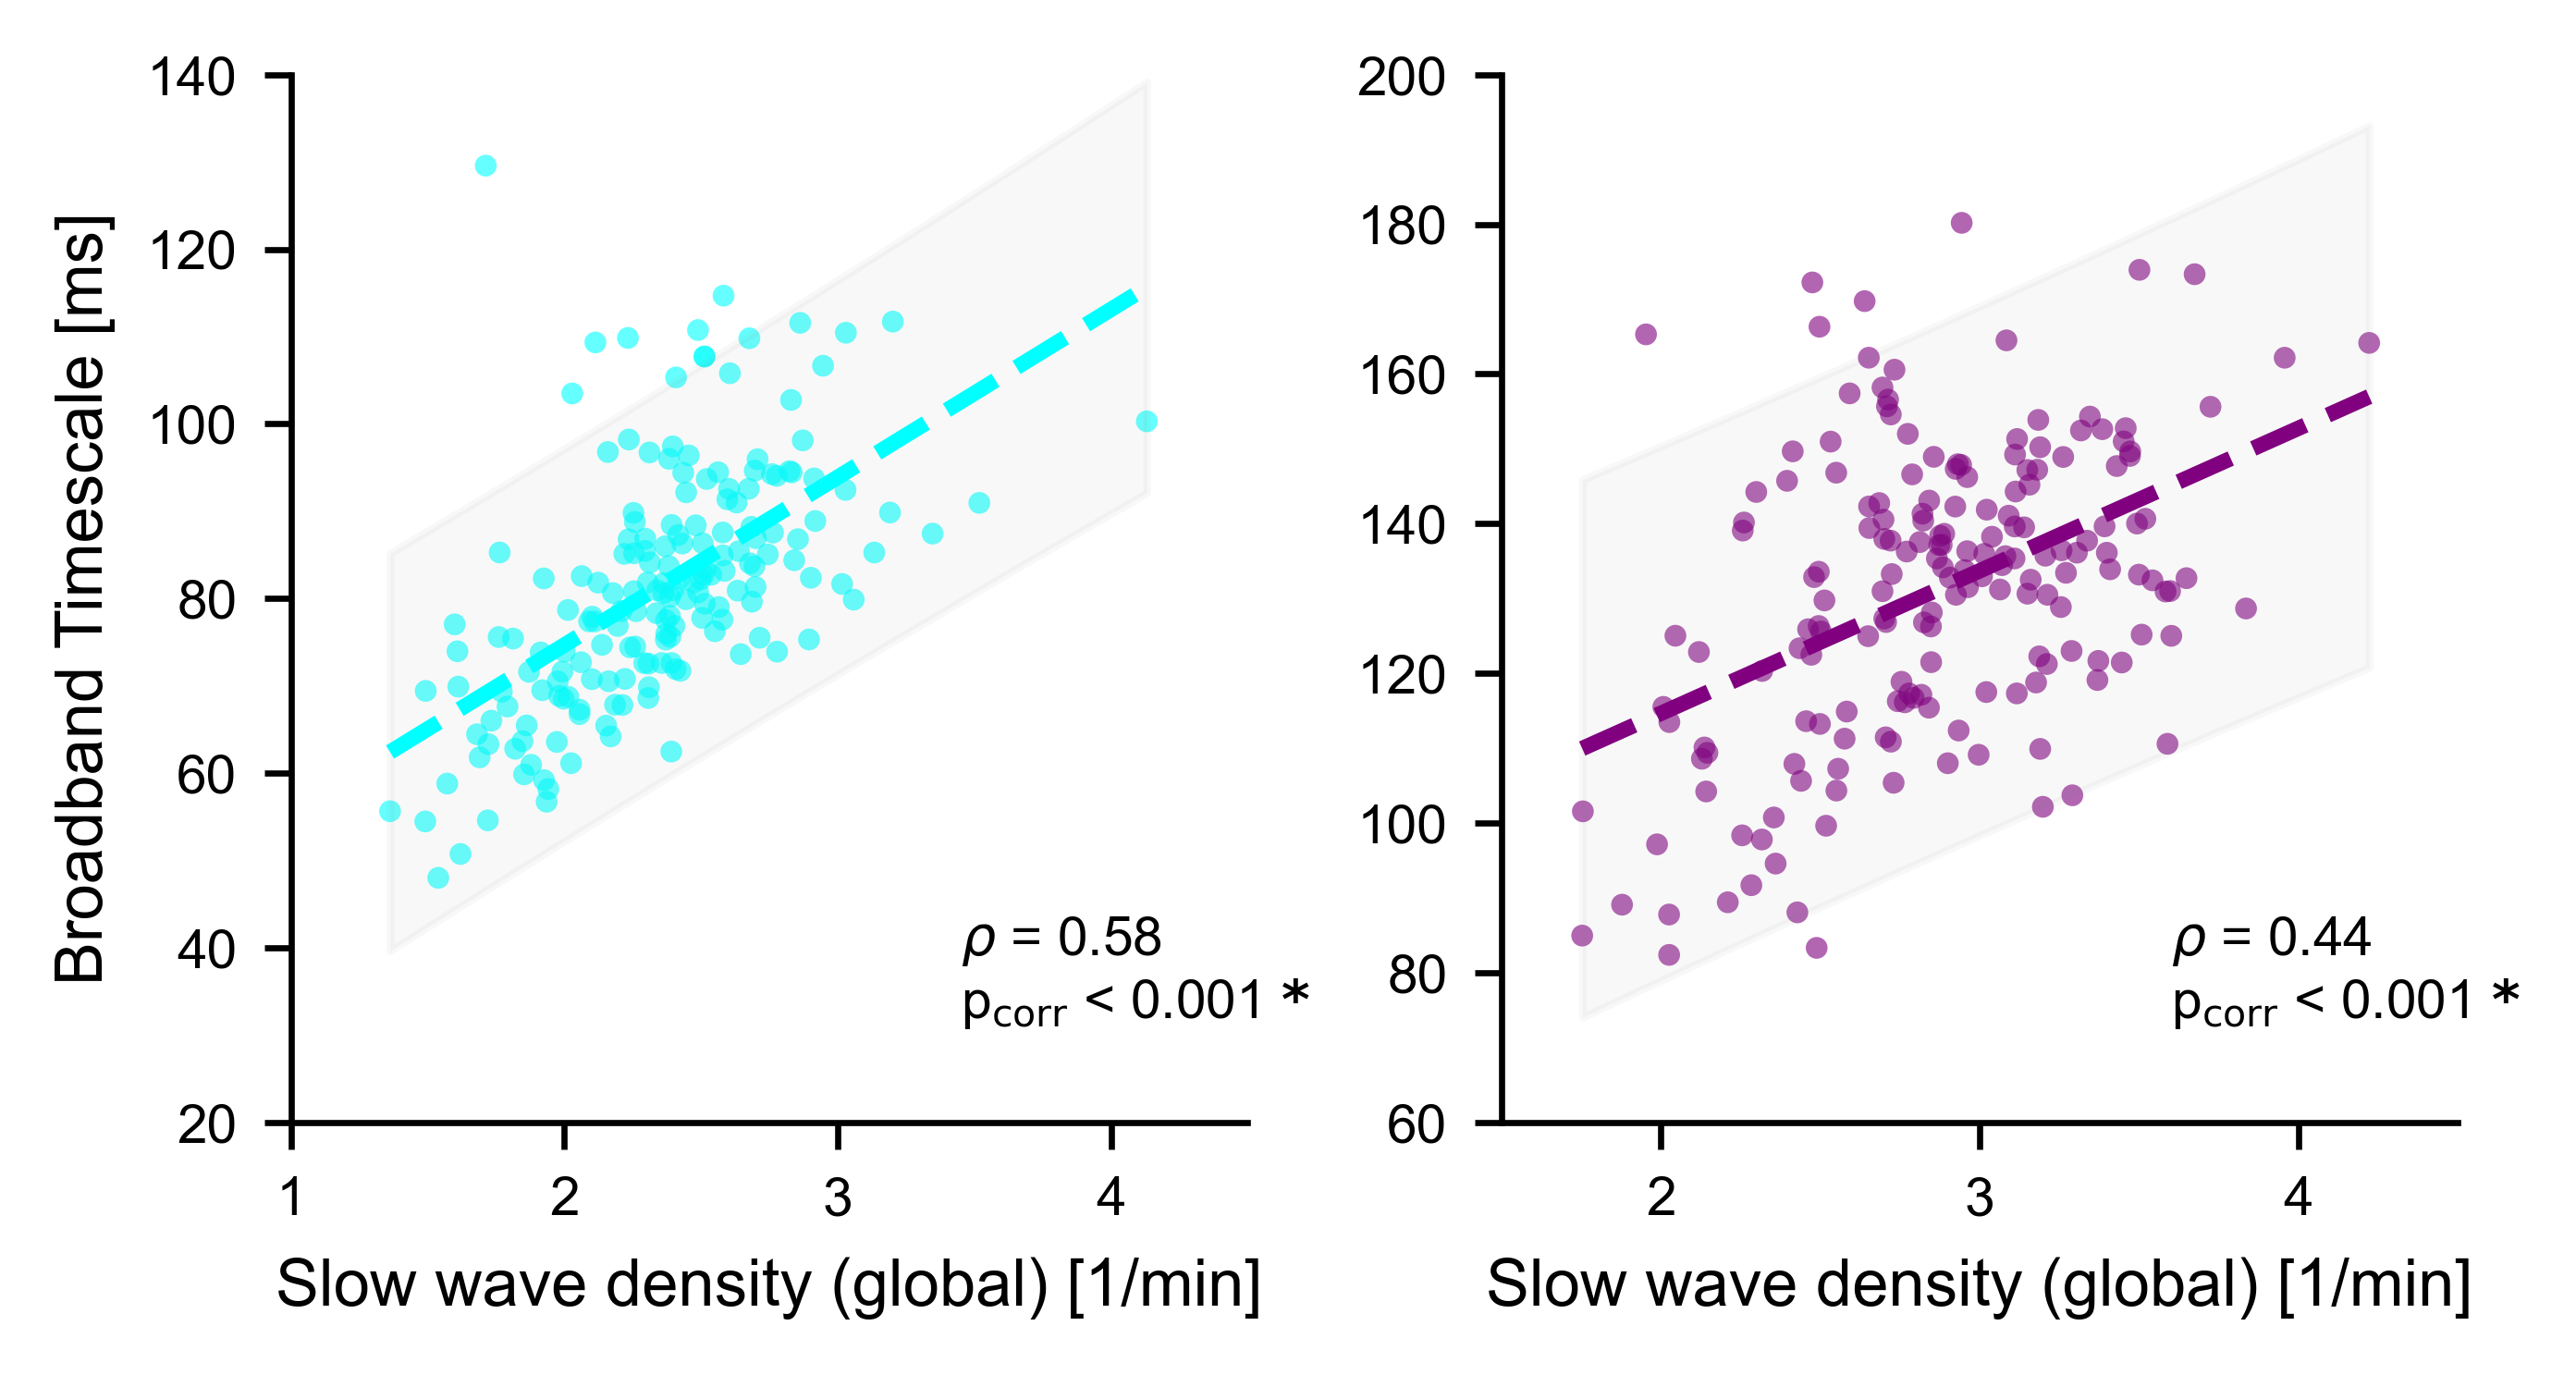

In [8]:
xlabels = {
    "total": "Slow wave density [1/min]",
    "local": "Slow wave density (local) [1/min]",
    "global": "Slow wave density (global) [1/min]",
}

xlims_stages = {
    "total": {"N2": (3.0, 6.0), "N3": (4, 8)},
    "local": {"N2": (1, 3.5), "N3": (1.5, 5)},
    "global": {"N2": (1, 4.5), "N3": (1.5, 4.5)},
}
ylims_stages = {"N2": (20, 140), "N3": (60, 200)}


for cond, df_metric in zip(
    ["total", "local", "global"],
    [df_density_stages, df_density_stages_local, df_density_stages_global],
):

    fig, axs = plt.subplots(
        1,
        len(stages),
        figsize=plots._get_figsize_inches((11.5, 6)),
        dpi=600,
        layout="constrained",
    )

    rhos, p_corrs, rhos_boot = {}, {}, {}

    for i, stage in enumerate(stages):
        # Import dataframe
        df_tau = df_timescales_stages[stage].copy()
        df_sw = df_metric[stage].copy()

        # Get data
        x = df_sw.to_numpy().squeeze()
        y = df_tau.loc[df_sw.index].to_numpy().squeeze()

        # Get correlation values
        rho, p_corr = utils.get_pcorr(
            x, y, map_coords, method="vasa", corr_type=corr_type
        )
        rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
        rhos[stage] = rho
        p_corrs[stage] = p_corr
        rhos_boot[stage] = rho_boot

        # Plot
        axs[i] = plots.plot_corr(
            axs[i],
            x,
            y,
            rho,
            p_corr,
            markersize=8,
            xy_annot=(0.7, 0.1),
            color=stage_colors[stage],
            xlabel=xlabels[cond],
            ylabel="Broadband Timescale [ms]",
            xlims=xlims_stages[cond][stage],
            ylims=ylims_stages[stage],
        )
        if i != 0:
            axs[i].set_ylabel("", fontsize=0)

    # Save figure
    plots.save_figure(fig, fig_path.joinpath(f"sw_tau_corr_{cond}.svg"))

    plt.show()

#### Gamma timescales

Generating 1000 permutations...
Generating 1000 permutations...


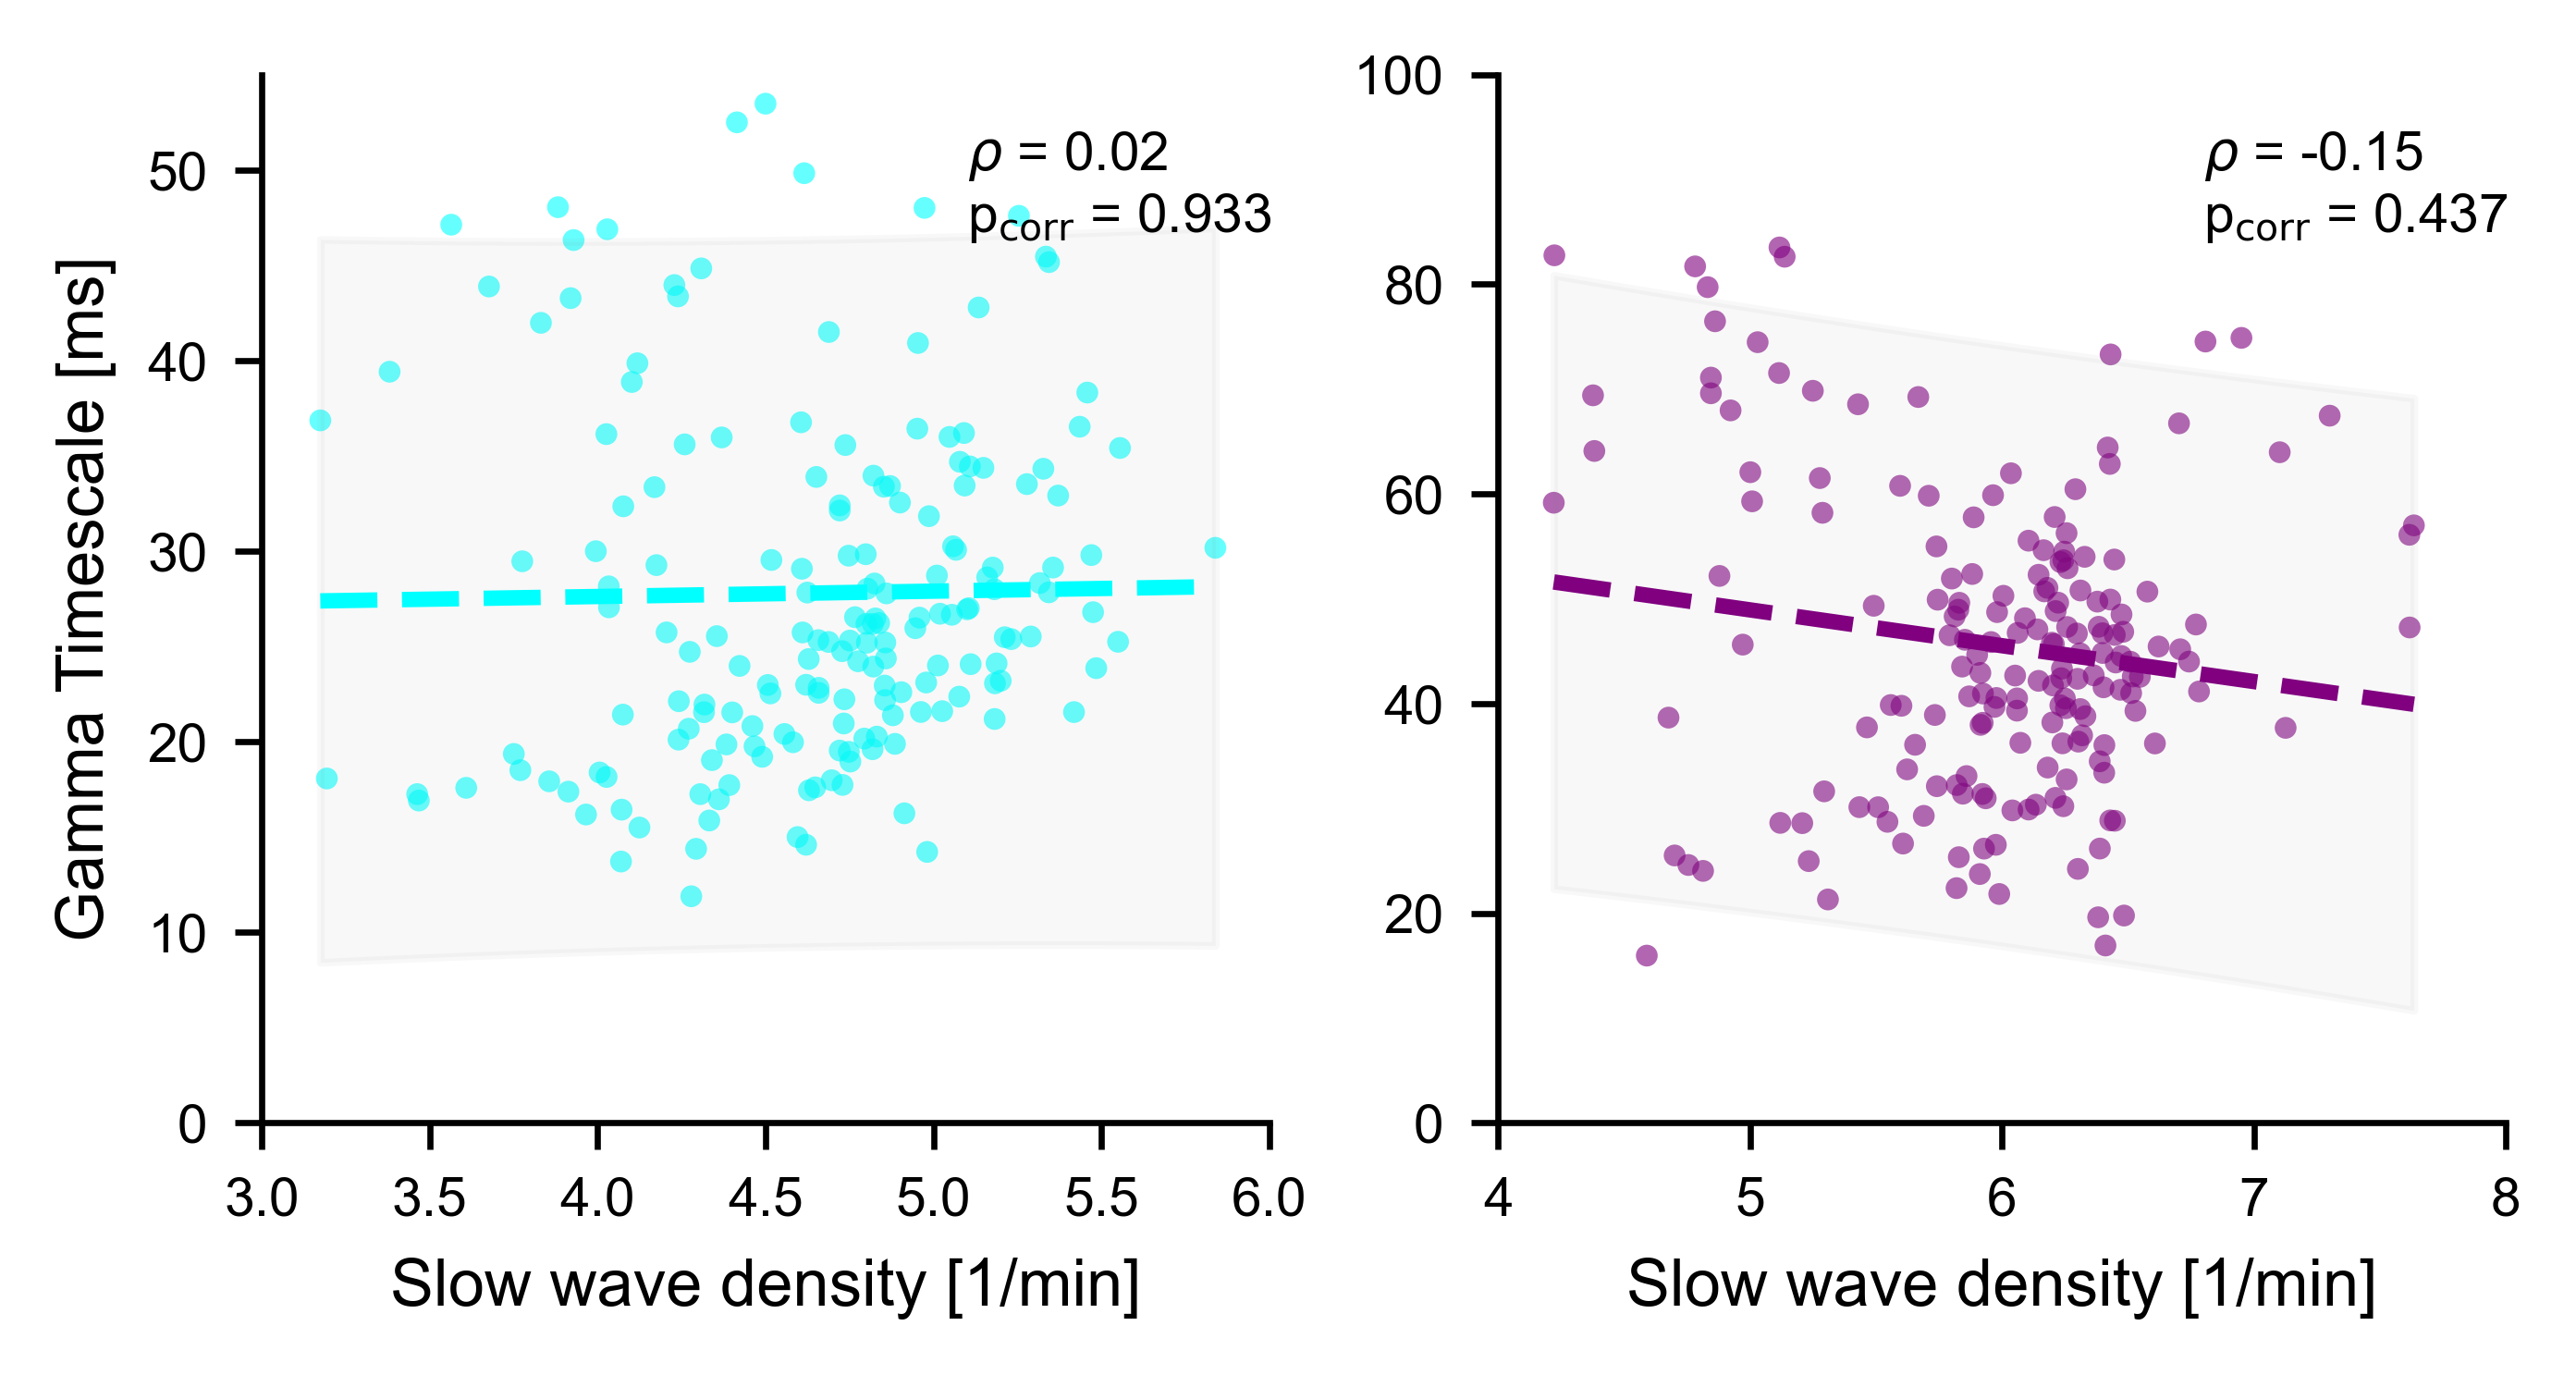

Generating 1000 permutations...
Generating 1000 permutations...


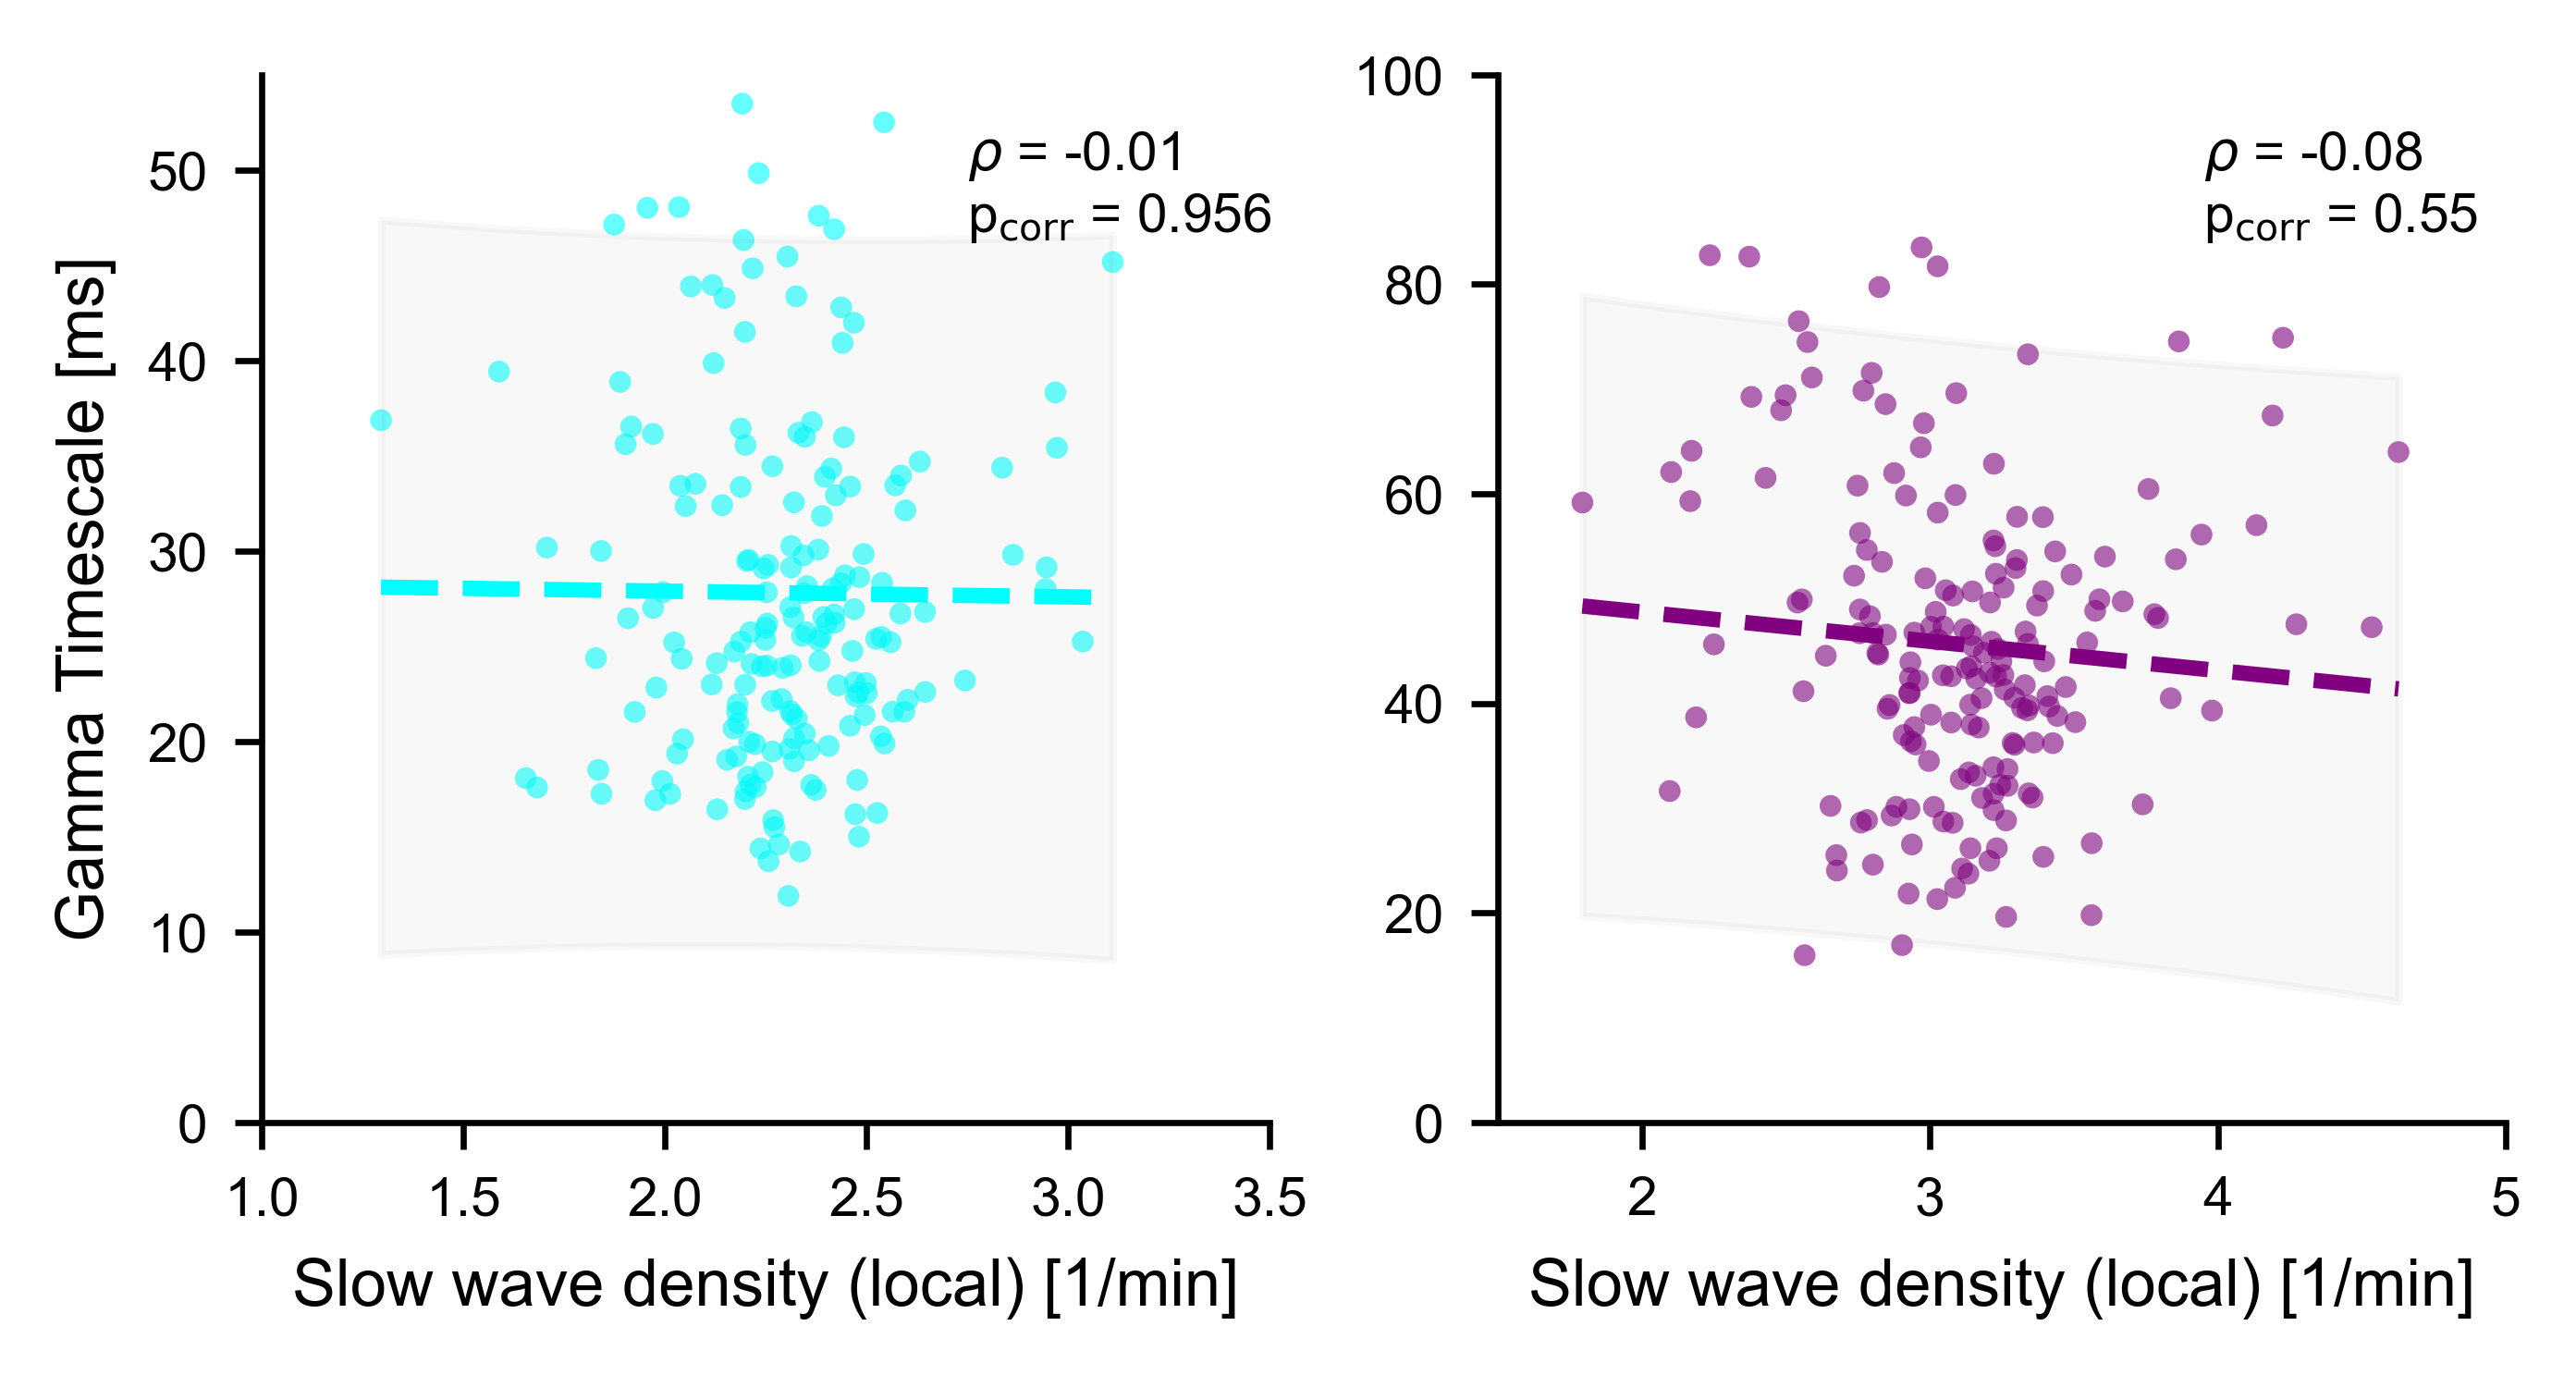

Generating 1000 permutations...
Generating 1000 permutations...


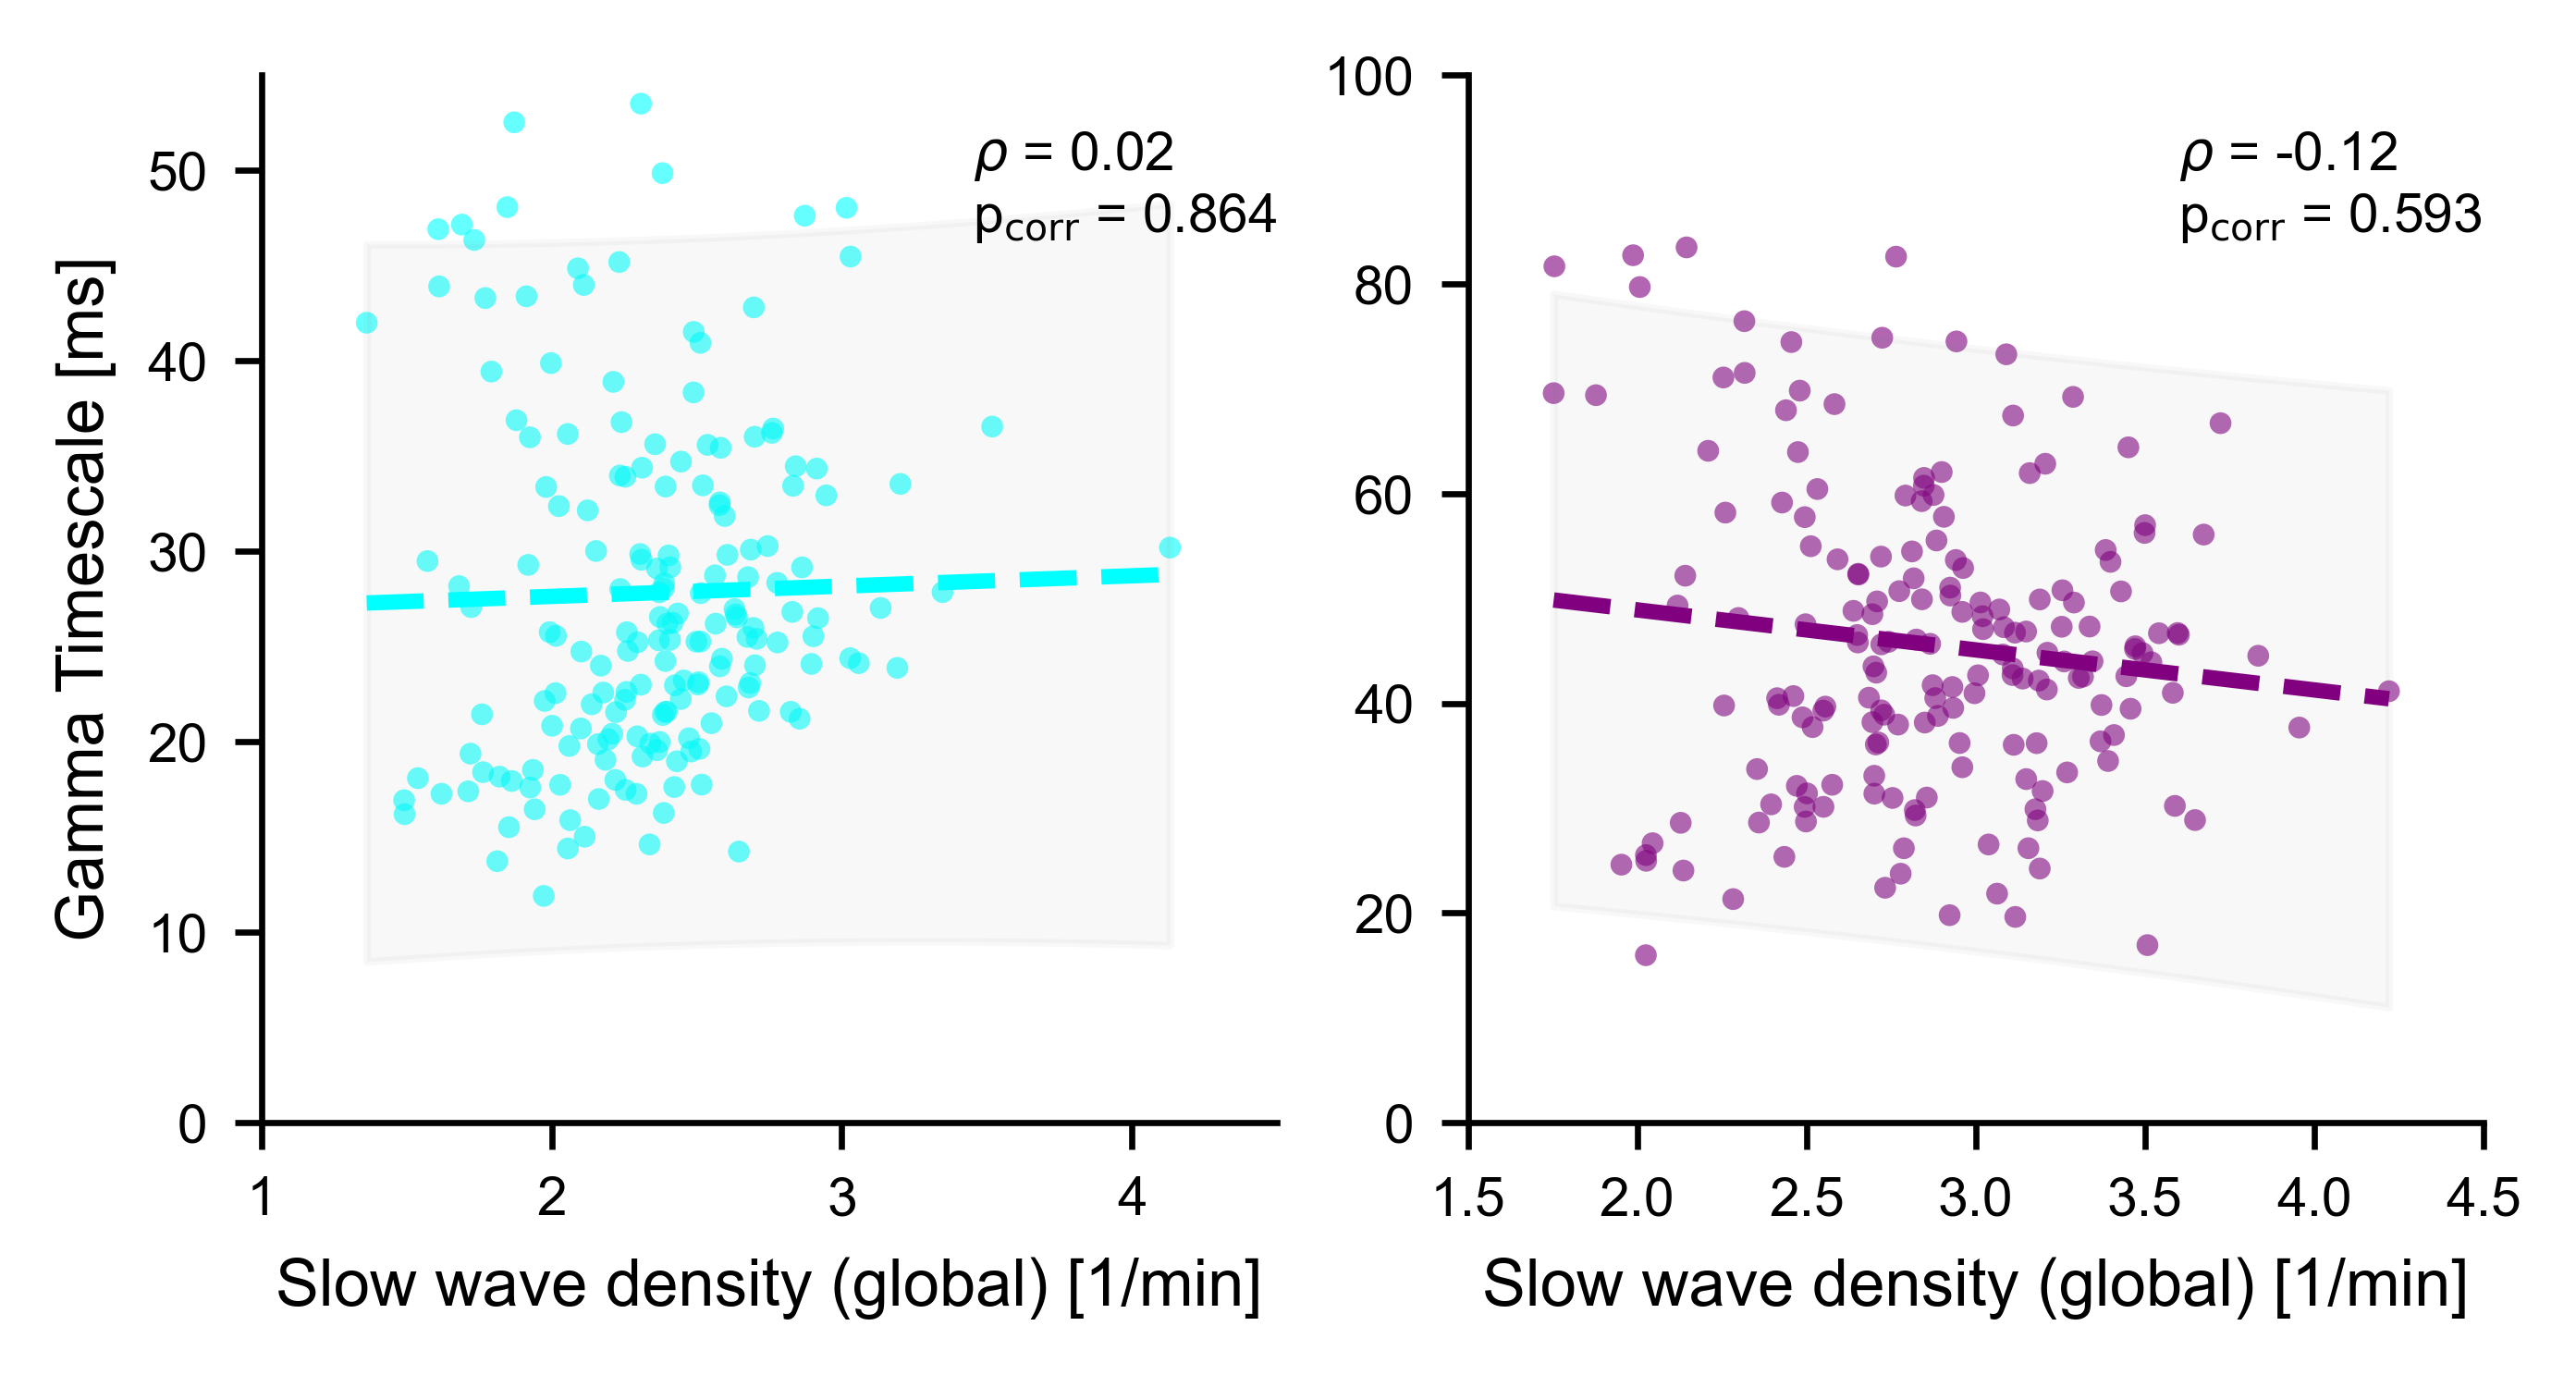

In [9]:
xlabels = {
    "total": "Slow wave density [1/min]",
    "local": "Slow wave density (local) [1/min]",
    "global": "Slow wave density (global) [1/min]",
}

xlims_stages = {
    "total": {"N2": (3.0, 6.0), "N3": (4, 8)},
    "local": {"N2": (1, 3.5), "N3": (1.5, 5)},
    "global": {"N2": (1, 4.5), "N3": (1.5, 4.5)},
}
ylims_stages = {"N2": (0, 55), "N3": (0, 100)}


for cond, df_metric in zip(
    ["total", "local", "global"],
    [df_density_stages, df_density_stages_local, df_density_stages_global],
):

    fig, axs = plt.subplots(
        1,
        len(stages),
        figsize=plots._get_figsize_inches((11.5, 6)),
        dpi=600,
        layout="constrained",
    )

    rhos, p_corrs, rhos_boot = {}, {}, {}

    for i, stage in enumerate(stages):
        # Import dataframe
        df_tau = df_timescales_stages_gamma[stage].copy()
        df_sw = df_metric[stage].copy()

        # Get data
        x = df_sw.to_numpy().squeeze()
        y = df_tau.loc[df_sw.index].to_numpy().squeeze()

        # Get correlation values
        rho, p_corr = utils.get_pcorr(
            x, y, map_coords, method="vasa", corr_type=corr_type
        )
        rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
        rhos[stage] = rho
        p_corrs[stage] = p_corr
        rhos_boot[stage] = rho_boot

        # Plot
        axs[i] = plots.plot_corr(
            axs[i],
            x,
            y,
            rho,
            p_corr,
            markersize=8,
            # xy_annot=(0.7, 0.1),
            color=stage_colors[stage],
            xlabel=xlabels[cond],
            ylabel="Gamma Timescale [ms]",
            xlims=xlims_stages[cond][stage],
            ylims=ylims_stages[stage],
        )
        if i != 0:
            axs[i].set_ylabel("", fontsize=0)

    # Save figure
    plots.save_figure(fig, fig_path.joinpath(f"sw_tau_gamma_corr_{cond}.svg"))

    plt.show()

### C) Changes of timescales during SWs 

Grand-average slow wave

In [37]:
with open(sw_path.joinpath("epochs_sw_N3.pkl"), "rb") as f:
    epo_sw_N3 = pickle.load(f)
with open(sw_path.joinpath("epochs_gamma_N3.pkl"), "rb") as f:
    epo_gamma_N3 = pickle.load(f)

# Average on channels and subjects
epo_sw_N3_avg = np.concatenate(
    [
        np.concatenate(
            [epo_sw.mean(axis=0).reshape(1, -1) for epo_sw in epo_sw_N3_pat.values()],
            axis=0,
        ).mean(axis=0).reshape(1, -1)
        for epo_sw_N3_pat in epo_sw_N3.values()
    ],
    axis= 0
)
epo_gamma_N3_avg = np.concatenate(
    [
        np.concatenate(
            [epo_gamma.mean(axis=0).reshape(1, -1) for epo_gamma in epo_gamma_N3_pat.values()],
            axis=0,
        ).mean(axis=0).reshape(1, -1)
        for epo_gamma_N3_pat in epo_gamma_N3.values()
    ],
    axis= 0
)

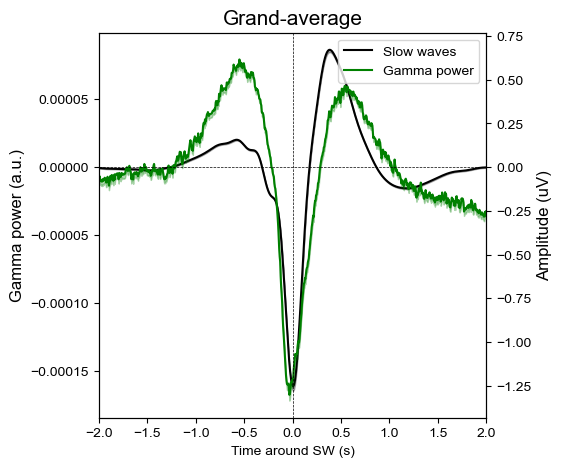

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plots_sw.plot_sw_gamma_single(
    ax,
    epo_sw_N3_avg,
    epo_gamma_N3_avg,
    2,
    ch_name="Grand-average",
)
ax.set_xlim(-2, 2)
ax.set_xlabel("Time around SW (s)")
plt.show()

In [47]:
df_timescales_sw = pd.read_csv("F:\\MNIOpen\\Results\\timescales_sw_test\\timescales_sw_N3.csv", index_col=0)
df_timescales_sw = df_timescales_sw[df_timescales_sw["time"].isin([-1, -0.5, 0, 0.5, 1])]
df_timescales_sw = df_timescales_sw[["pat", "time", "tau"]].groupby(["pat", "time"]).mean().reset_index().pivot(index="pat", columns="time", values="tau")

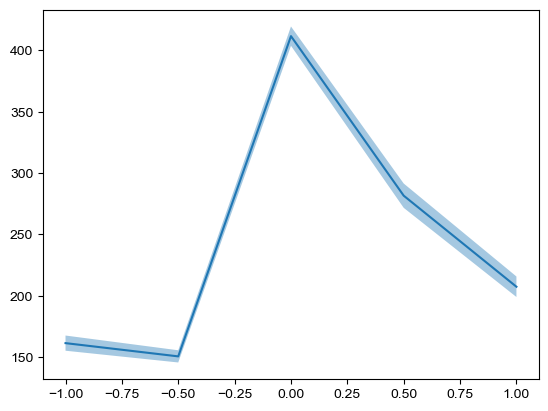

In [49]:
plt.plot(df_timescales_sw.columns, df_timescales_sw.mean())
plt.fill_between(df_timescales_sw.columns, 
df_timescales_sw.mean() - df_timescales_sw.sem(),
df_timescales_sw.mean() + df_timescales_sw.sem(),
alpha=0.4
)

### S1) Correlate SW maps to T1w/T2w

Generating 1000 permutations...
Generating 1000 permutations...


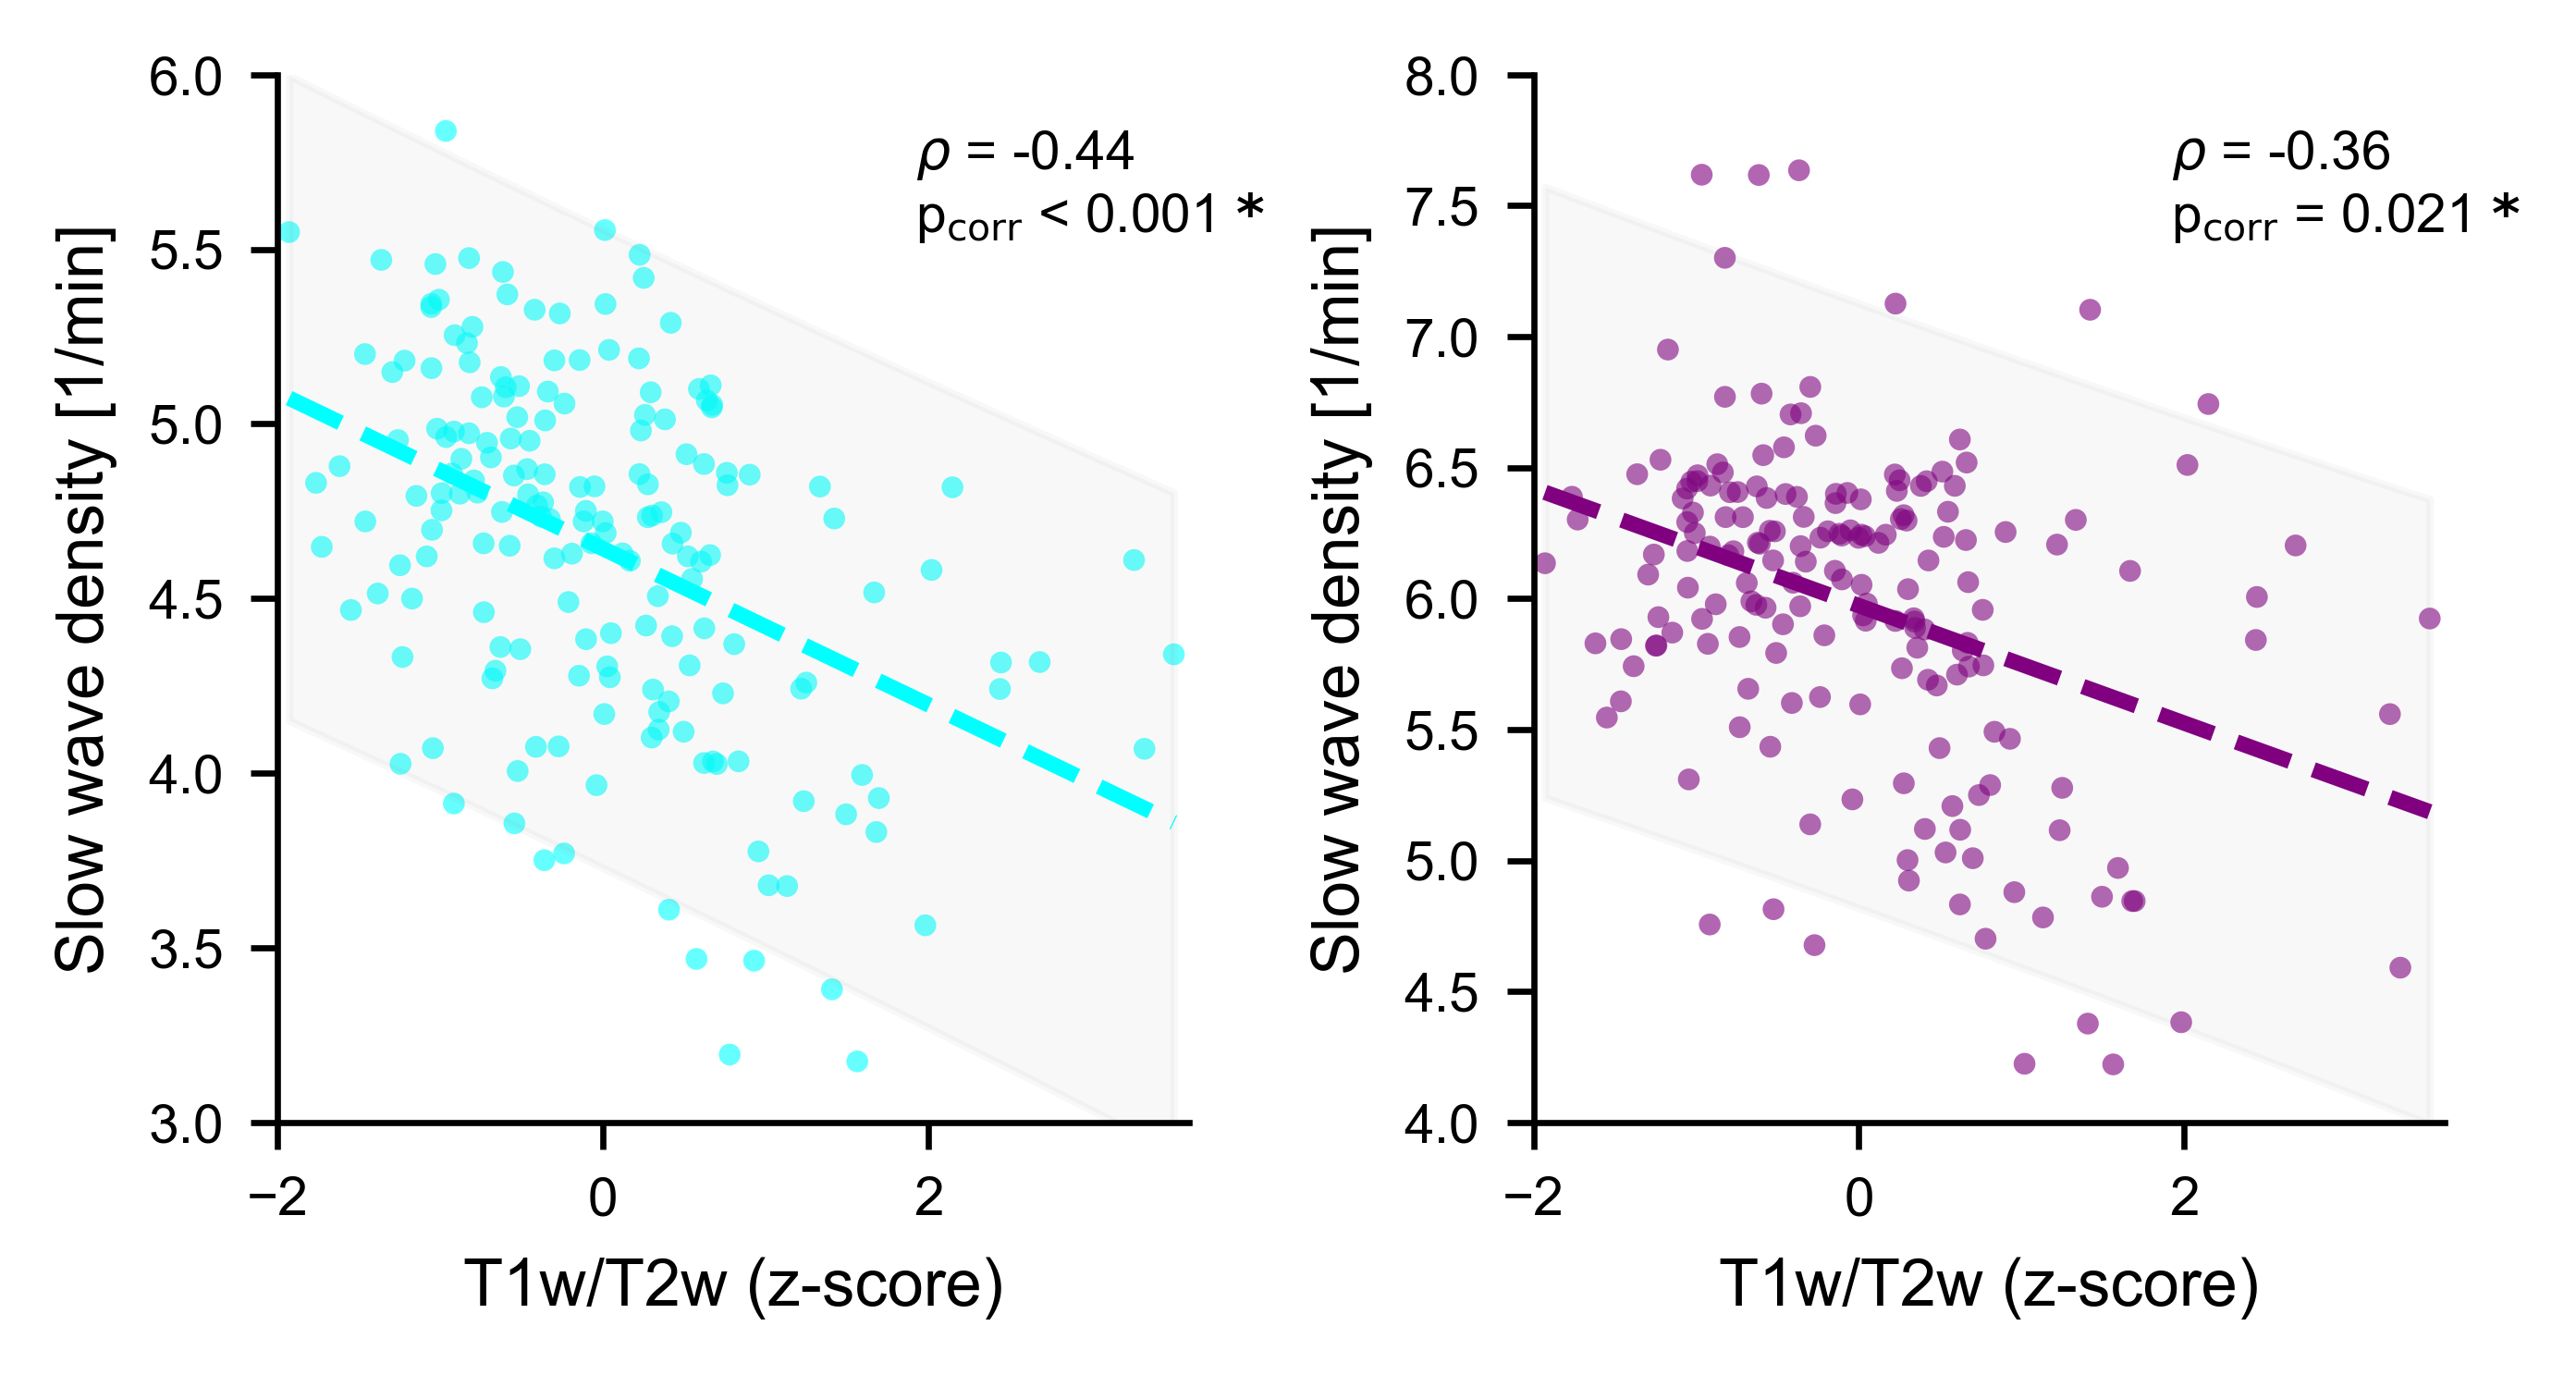

Generating 1000 permutations...
Generating 1000 permutations...


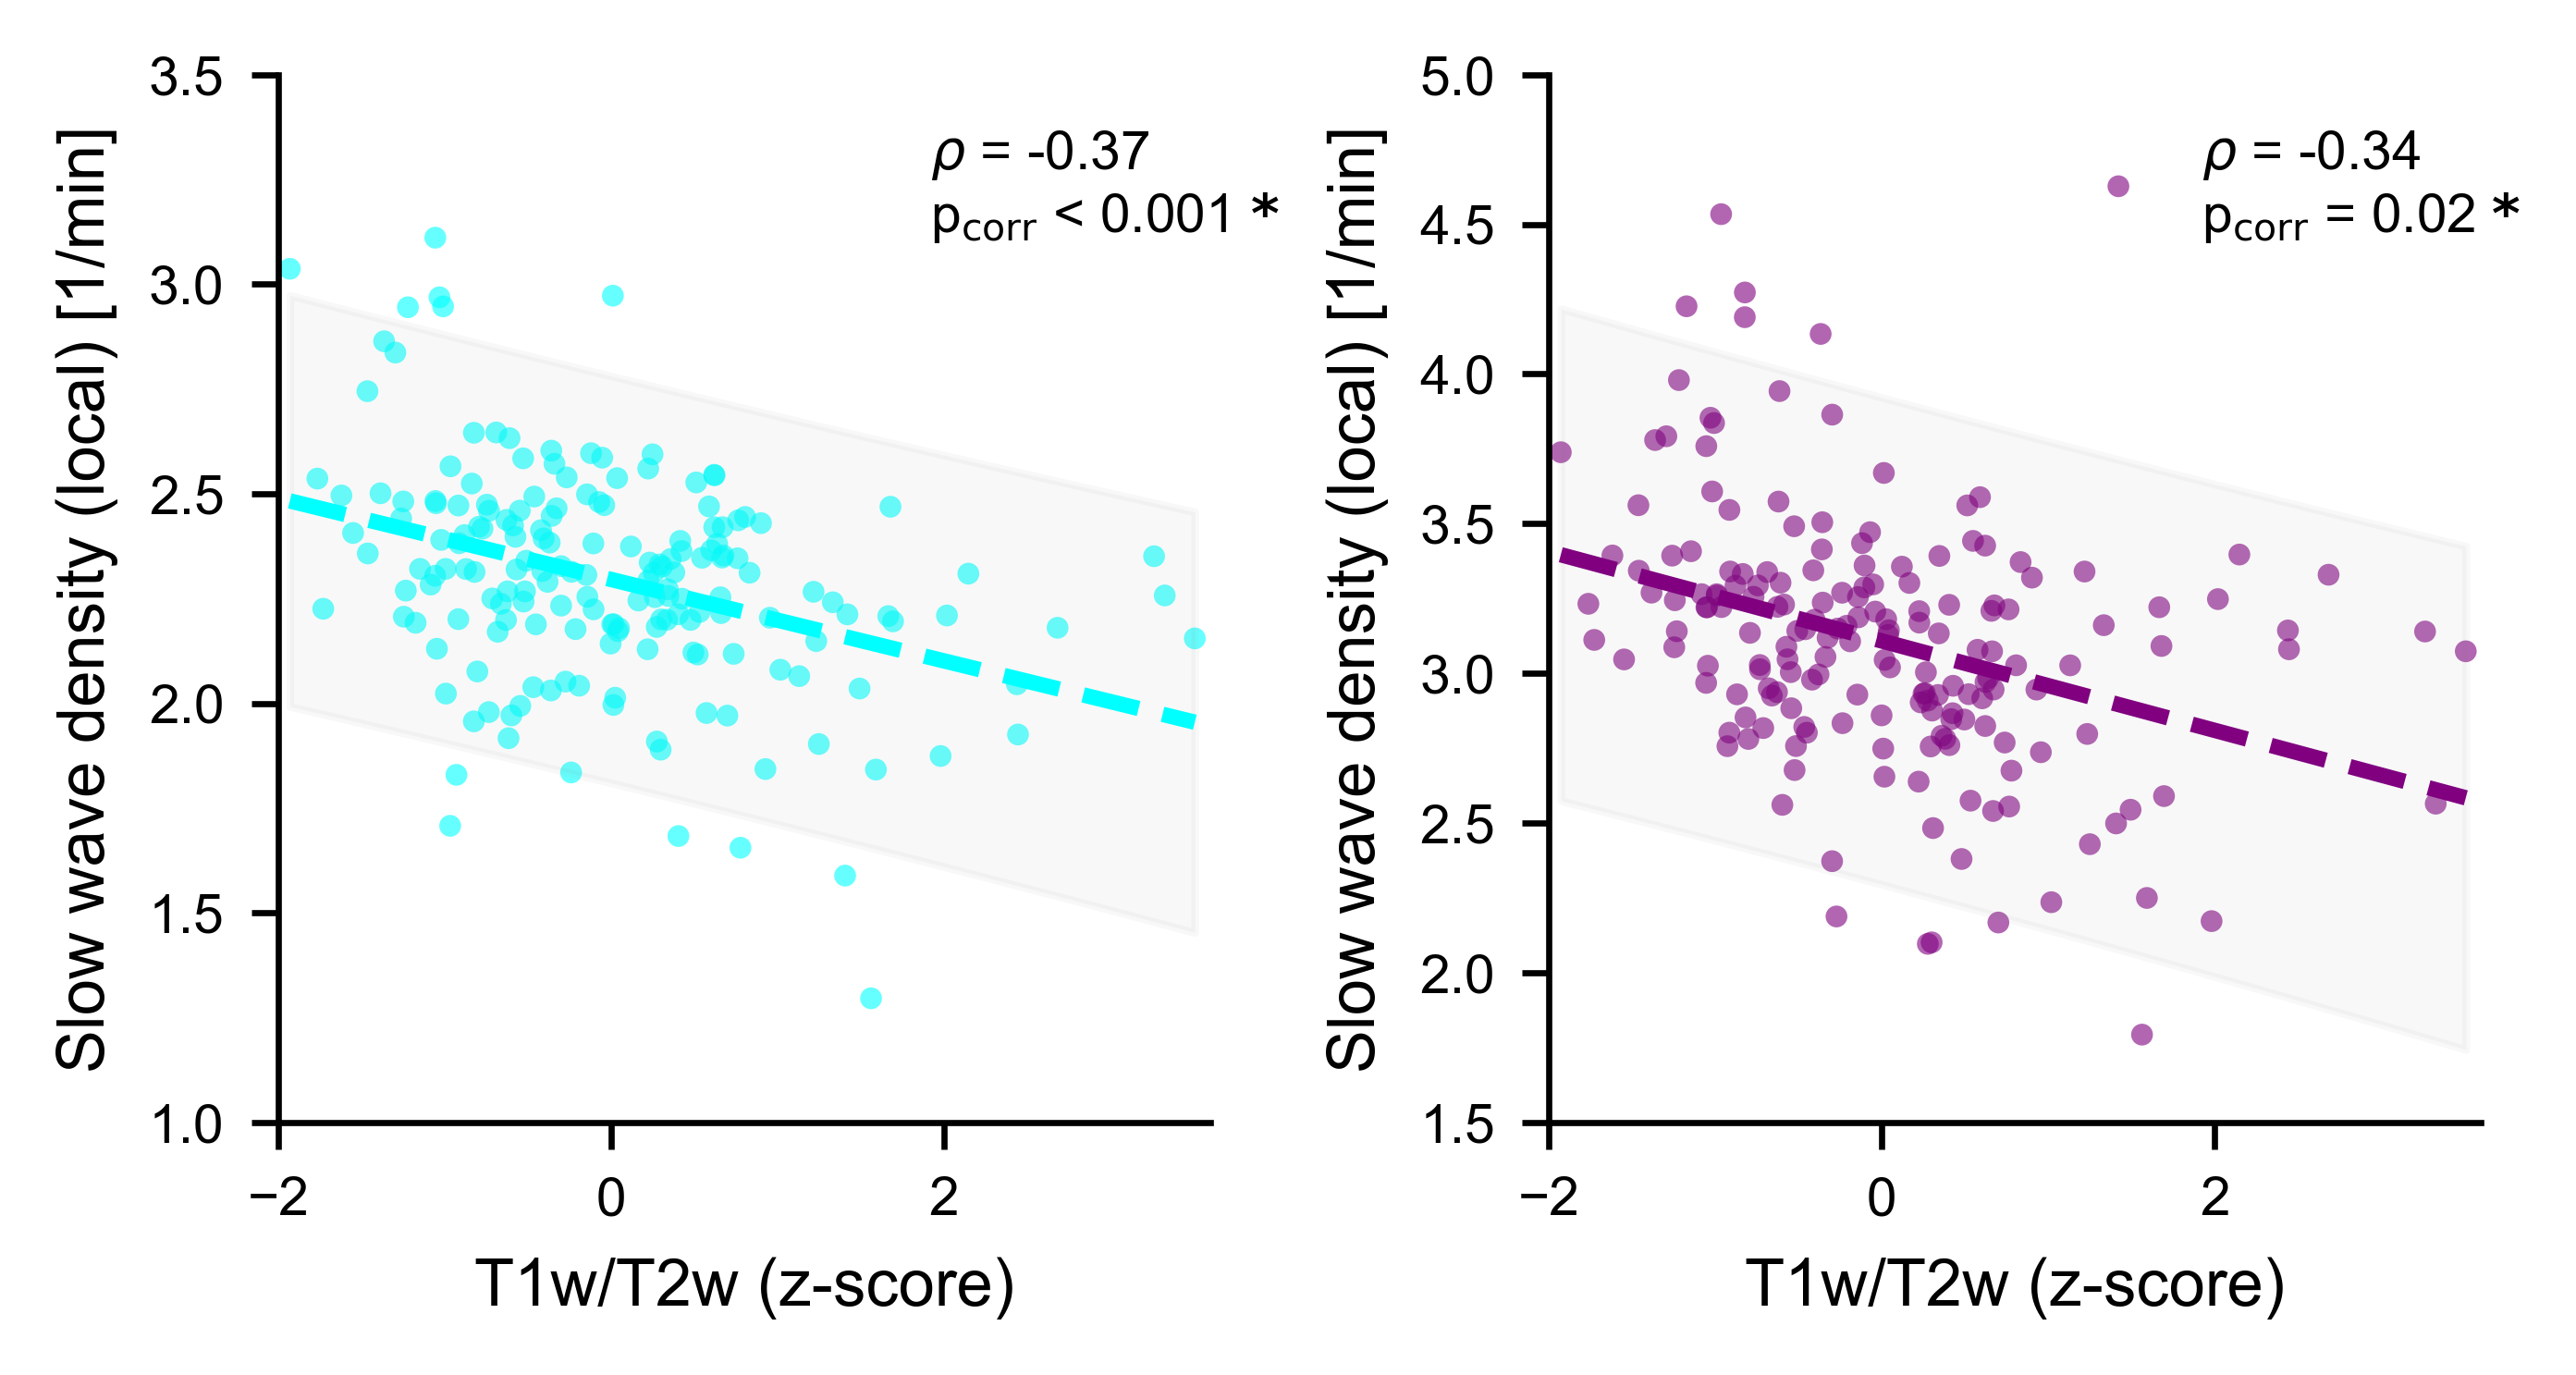

Generating 1000 permutations...
Generating 1000 permutations...


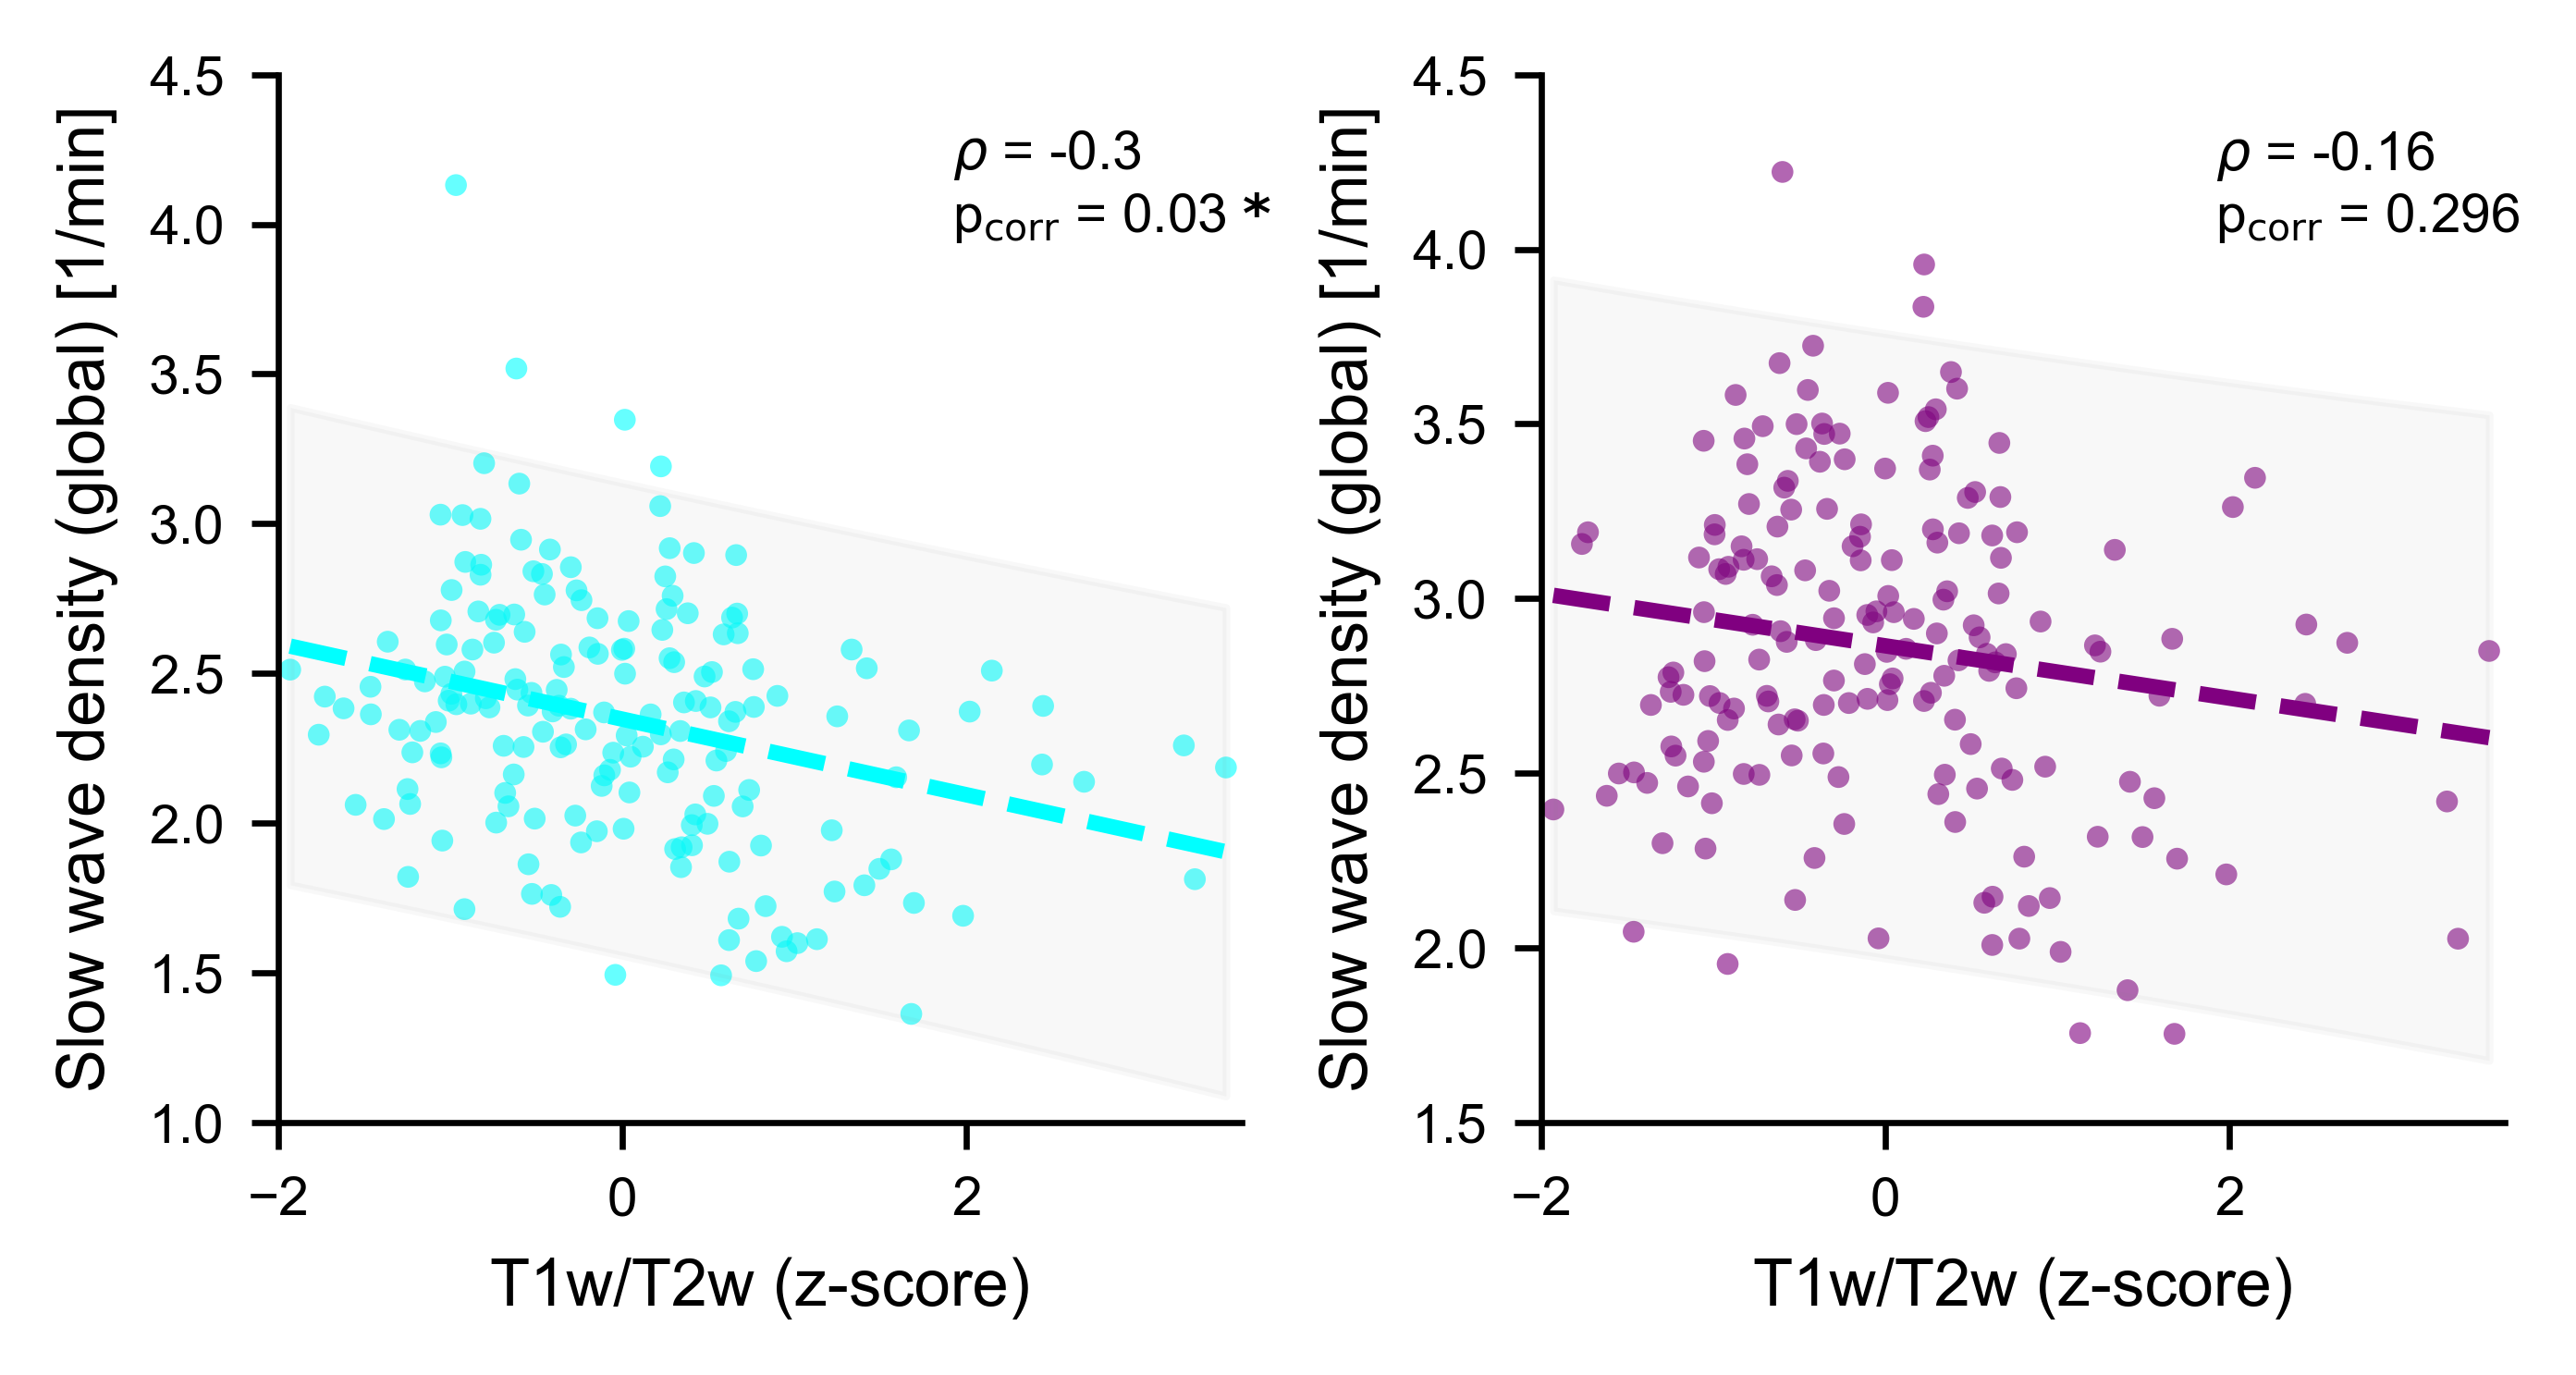

In [10]:
df_struct = pd.read_csv(
    data_path.joinpath("Data", "Raw", "df_structural_avg.csv"), index_col=0
)

xlims = (-2, 3.6)

ylabels = {
    "total": "Slow wave density [1/min]",
    "local": "Slow wave density (local) [1/min]",
    "global": "Slow wave density (global) [1/min]",
}

ylims_stages = {
    "total": {"N2": (3.0, 6.0), "N3": (4, 8)},
    "local": {"N2": (1, 3.5), "N3": (1.5, 5)},
    "global": {"N2": (1, 4.5), "N3": (1.5, 4.5)},
}


for cond, df_metric in zip(
    ["total", "local", "global"],
    [df_density_stages, df_density_stages_local, df_density_stages_global],
):

    fig, axs = plt.subplots(
        1,
        len(stages),
        figsize=plots._get_figsize_inches((11.5, 6)),
        dpi=600,
        layout="constrained",
    )

    rhos, p_corrs, rhos_boot = {}, {}, {}

    for i, stage in enumerate(stages):
        # Import dataframe
        # df_ = df_timescales_stages[stage].copy()
        df_sw = df_metric[stage].copy()

        # Get data
        x = zscore(df_struct["T1T2"], ddof=1).to_numpy()
        y = df_sw.loc[df_struct.index].to_numpy().squeeze()

        # Get correlation values
        rho, p_corr = utils.get_pcorr(
            x, y, map_coords, method="vasa", corr_type=corr_type
        )
        rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
        rhos[stage] = rho
        p_corrs[stage] = p_corr
        rhos_boot[stage] = rho_boot

        # Plot
        axs[i] = plots.plot_corr(
            axs[i],
            x,
            y,
            rho,
            p_corr,
            markersize=8,
            # xy_annot=(0.7, 0.1),
            color=stage_colors[stage],
            xlabel="T1w/T2w (z-score)",
            ylabel=ylabels[cond],
            xlims=(-2, 3.6),
            ylims=ylims_stages[cond][stage],
        )

    # Save figure
    plots.save_figure(fig, fig_path.joinpath(f"sw_struct_corr_{cond}.svg"))

    plt.show()